# EDA: TMDB v11 + MovieLens 32M

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
sns.set_theme(style='whitegrid', context='talk')

In [2]:
def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / 'Data').exists() and (candidate / 'src').exists():
            return candidate
    raise FileNotFoundError('Could not locate project root containing Data/ and src/.')

PROJECT_ROOT = find_project_root(Path.cwd())
DATA_DIR = PROJECT_ROOT / 'Data'

TMDB_PATH = DATA_DIR / 'TMDB_movie_dataset_v11.csv'
MOVIES_PATH = DATA_DIR / 'ml-32m' / 'movies.csv'
RATINGS_PATH = DATA_DIR / 'ml-32m' / 'ratings.csv'
TAGS_PATH = DATA_DIR / 'ml-32m' / 'tags.csv'
LINKS_PATH = DATA_DIR / 'ml-32m' / 'links.csv'

TMDB_SEMANTIC_PATH = DATA_DIR / 'outputs' / 'tmdb_semantic_catalog_alllangs_with_new_movies.csv'
MERGED_PATH = DATA_DIR / 'outputs' / 'movielens_tmdb_merged.csv'

paths = {
    'TMDB original': TMDB_PATH,
    'MovieLens movies': MOVIES_PATH,
    'MovieLens ratings': RATINGS_PATH,
    'MovieLens tags': TAGS_PATH,
    'MovieLens links': LINKS_PATH,
    'Created TMDB semantic catalog': TMDB_SEMANTIC_PATH,
    'Created MovieLens-TMDB merged': MERGED_PATH,
}

file_manifest = pd.DataFrame(
    {
        'dataset': list(paths.keys()),
        'path': [str(p) for p in paths.values()],
        'exists': [p.exists() for p in paths.values()],
        'size_gb': [round((p.stat().st_size / (1024**3)), 3) if p.exists() else np.nan for p in paths.values()],
    }
)
file_manifest

dataset  \
0                  TMDB original   
1               MovieLens movies   
2              MovieLens ratings   
3                 MovieLens tags   
4                MovieLens links   
5  Created TMDB semantic catalog   
6  Created MovieLens-TMDB merged   

                                                path  exists  size_gb  
0  /Users/roop/Library/CloudStorage/OneDrive-Univ...    True    0.567  
1  /Users/roop/Library/CloudStorage/OneDrive-Univ...    True    0.004  
2  /Users/roop/Library/CloudStorage/OneDrive-Univ...    True    0.817  
3  /Users/roop/Library/CloudStorage/OneDrive-Univ...    True    0.067  
4  /Users/roop/Library/CloudStorage/OneDrive-Univ...    True    0.002  
5  /Users/roop/Library/CloudStorage/OneDrive-Univ...    True    1.003  
6  /Users/roop/Library/CloudStorage/OneDrive-Univ...    True    0.136

## 1) TMDB Original Dataset EDA


In [3]:
# columns in each dataset
for name, path in paths.items():
    if path.exists() and path.suffix == '.csv':
        df = pd.read_csv(path, nrows=0)  # read only header
        print(f"{name} columns: {list(df.columns)}")  

TMDB original columns: ['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']
MovieLens movies columns: ['movieId', 'title', 'genres']
MovieLens ratings columns: ['userId', 'movieId', 'rating', 'timestamp']
MovieLens tags columns: ['userId', 'movieId', 'tag', 'timestamp']
MovieLens links columns: ['movieId', 'imdbId', 'tmdbId']
Created TMDB semantic catalog columns: ['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords', 'year', 'movieDoc'

In [4]:
tmdb_usecols = [
    'id', 'title', 'release_date', 'original_language', 'vote_average',
    'vote_count', 'popularity', 'runtime', 'adult', 'overview', 'genres', 'keywords'
]

tmdb = pd.read_csv(TMDB_PATH, usecols=tmdb_usecols, low_memory=False)

# Basic cleaning
for col in ['vote_average', 'vote_count', 'popularity', 'runtime']:
    tmdb[col] = pd.to_numeric(tmdb[col], errors='coerce')

tmdb['id'] = pd.to_numeric(tmdb['id'], errors='coerce').astype('Int64')
tmdb['release_date'] = pd.to_datetime(tmdb['release_date'], errors='coerce')
tmdb['release_year'] = tmdb['release_date'].dt.year.astype('Int64')
tmdb['original_language'] = tmdb['original_language'].fillna('unknown').astype(str).str.lower()

tmdb.shape

(1368726, 13)

In [5]:
tmdb_missing = (
    tmdb.isna().mean().mul(100).sort_values(ascending=False).rename('missing_pct').to_frame().round(2)
)

def non_empty_pct(series: pd.Series) -> float:
    s = series.fillna('').astype(str).str.strip()
    return round(float((s != '').mean() * 100), 2)

tmdb_text_completeness = pd.Series(
    {
        'overview_non_empty_pct': non_empty_pct(tmdb['overview']),
        'genres_non_empty_pct': non_empty_pct(tmdb['genres']),
        'keywords_non_empty_pct': non_empty_pct(tmdb['keywords']),
    },
    name='value'
)

print('TMDB rows:', f"{len(tmdb):,}")
print('TMDB unique ids:', f"{tmdb['id'].nunique(dropna=True):,}")
display(tmdb_missing)
display(tmdb_text_completeness.to_frame())

TMDB rows: 1,368,726
TMDB unique ids: 1,367,545


missing_pct
keywords                 74.93
genres                   43.34
overview                 22.64
release_date             21.21
release_year             21.21
title                     0.00
id                        0.00
vote_average              0.00
vote_count                0.00
runtime                   0.00
adult                     0.00
original_language         0.00
popularity                0.00

value
overview_non_empty_pct  77.27
genres_non_empty_pct    56.66
keywords_non_empty_pct  25.07

/var/folders/lq/r8qjzl2x10b2vksfq2gq9m080000gn/T/ipykernel_21232/3979024378.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_lang.values, y=top_lang.index, ax=axes[0, 0], palette='viridis')


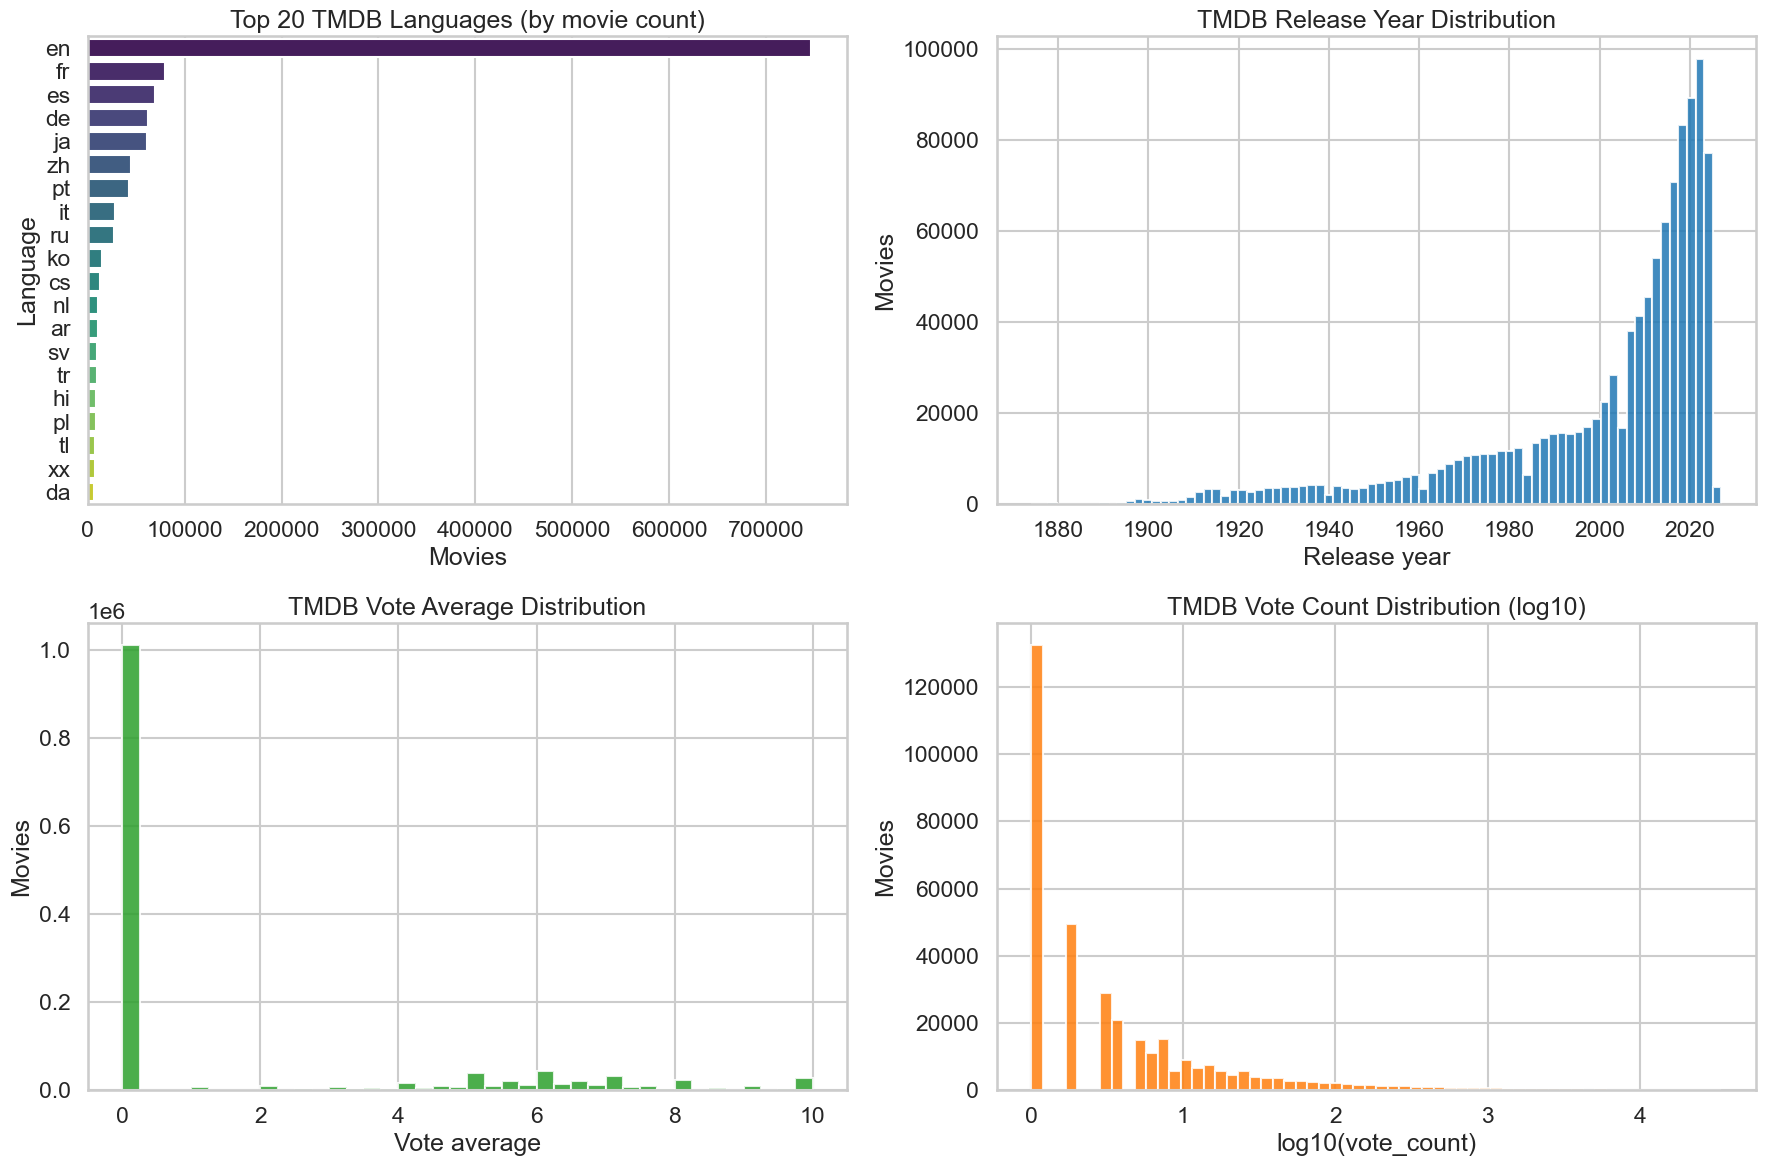

In [6]:
top_lang = tmdb['original_language'].value_counts().head(20)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

sns.barplot(x=top_lang.values, y=top_lang.index, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Top 20 TMDB Languages (by movie count)')
axes[0, 0].set_xlabel('Movies')
axes[0, 0].set_ylabel('Language')

valid_years = tmdb['release_year'].dropna().astype(int)
valid_years = valid_years[(valid_years >= 1870) & (valid_years <= pd.Timestamp.now().year + 1)]
axes[0, 1].hist(valid_years, bins=80, color='#1f77b4', alpha=0.85)
axes[0, 1].set_title('TMDB Release Year Distribution')
axes[0, 1].set_xlabel('Release year')
axes[0, 1].set_ylabel('Movies')

axes[1, 0].hist(tmdb['vote_average'].dropna(), bins=40, color='#2ca02c', alpha=0.85)
axes[1, 0].set_title('TMDB Vote Average Distribution')
axes[1, 0].set_xlabel('Vote average')
axes[1, 0].set_ylabel('Movies')

vote_count_nonzero = tmdb.loc[tmdb['vote_count'].fillna(0) > 0, 'vote_count']
axes[1, 1].hist(np.log10(vote_count_nonzero), bins=60, color='#ff7f0e', alpha=0.85)
axes[1, 1].set_title('TMDB Vote Count Distribution (log10)')
axes[1, 1].set_xlabel('log10(vote_count)')
axes[1, 1].set_ylabel('Movies')

plt.tight_layout()
plt.show()

Non-English movies: 622,221 (45.46%)


/var/folders/lq/r8qjzl2x10b2vksfq2gq9m080000gn/T/ipykernel_21232/3355847204.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=non_english_langs.values, y=non_english_langs.index, palette='magma')


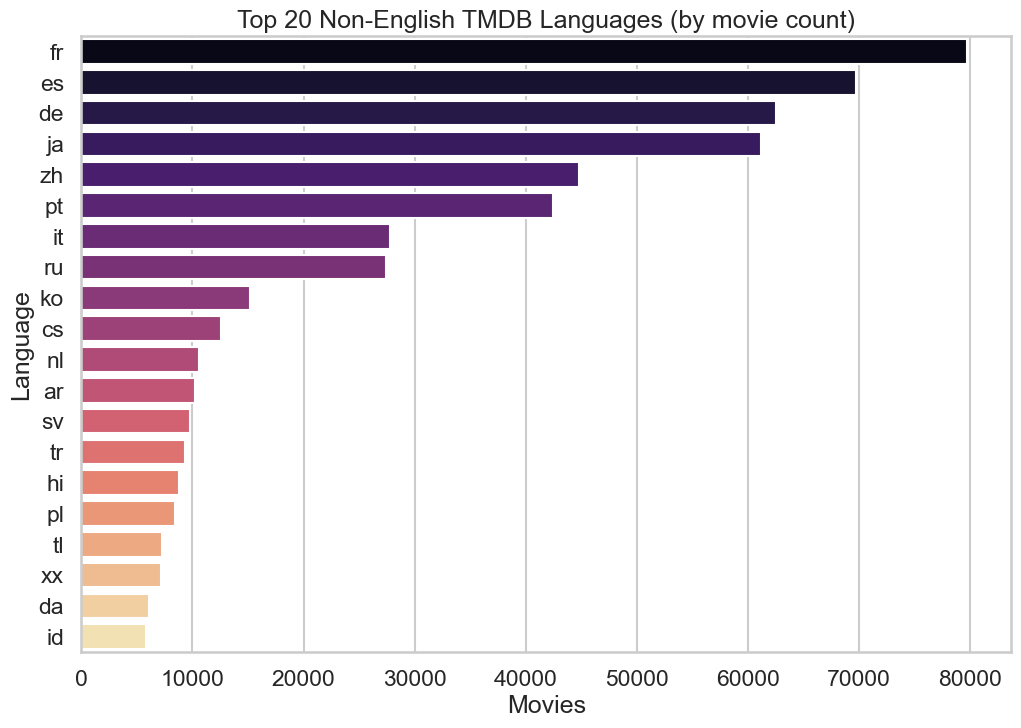

In [7]:
# movie count other than english plot
non_english_count = tmdb[tmdb['original_language'] != 'en'].shape[0]
total_count = tmdb.shape[0]
print(f"Non-English movies: {non_english_count:,} ({(non_english_count / total_count * 100):.2f}%)")

# plot of non - en language movies by language
non_english_langs = tmdb[tmdb['original_language'] != 'en']['original_language'].value_counts().head(20)
plt.figure(figsize=(12, 8))
sns.barplot(x=non_english_langs.values, y=non_english_langs.index, palette='magma')
plt.title('Top 20 Non-English TMDB Languages (by movie count)')
plt.xlabel('Movies')
plt.ylabel('Language')
plt.show()

## 2) MovieLens 32M Original Dataset EDA


In [8]:
movies = pd.read_csv(MOVIES_PATH)
links = pd.read_csv(LINKS_PATH)

print('MovieLens movies shape:', movies.shape)
print('MovieLens links shape:', links.shape)
display(movies.head())
display(links.head())

MovieLens movies shape: (87585, 3)
MovieLens links shape: (87585, 3)


movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

In [9]:
# Chunked pass over 32M ratings
rating_scale = pd.Index(np.round(np.arange(0.5, 5.0 + 0.5, 0.5), 1), name='rating')
rating_hist = pd.Series(0, index=rating_scale, dtype='int64')
ratings_per_user = pd.Series(dtype='int64')
ratings_per_movie = pd.Series(dtype='int64')
monthly_counts = pd.Series(dtype='int64')

rows_processed = 0
min_ts = None
max_ts = None

ratings_dtypes = {
    'userId': 'int32',
    'movieId': 'int32',
    'rating': 'float32',
    'timestamp': 'int64',
}

for i, chunk in enumerate(
    pd.read_csv(
        RATINGS_PATH,
        usecols=['userId', 'movieId', 'rating', 'timestamp'],
        dtype=ratings_dtypes,
        chunksize=2_000_000,
    ),
    start=1,
):
    rows_processed += len(chunk)

    ratings_per_user = ratings_per_user.add(chunk['userId'].value_counts(), fill_value=0)
    ratings_per_movie = ratings_per_movie.add(chunk['movieId'].value_counts(), fill_value=0)
    rating_hist = rating_hist.add(chunk['rating'].round(1).value_counts(), fill_value=0)

    ts = pd.to_datetime(chunk['timestamp'], unit='s', utc=True).dt.tz_convert(None)
    month_key = ts.dt.to_period('M').astype(str)
    monthly_counts = monthly_counts.add(month_key.value_counts(), fill_value=0)

    cmin = int(chunk['timestamp'].min())
    cmax = int(chunk['timestamp'].max())
    min_ts = cmin if min_ts is None else min(min_ts, cmin)
    max_ts = cmax if max_ts is None else max(max_ts, cmax)

    if i % 4 == 0:
        print(f'Processed {rows_processed:,} ratings rows...')

ratings_per_user = ratings_per_user.astype('int64')
ratings_per_movie = ratings_per_movie.astype('int64')
rating_hist = rating_hist.reindex(rating_scale, fill_value=0).astype('int64')
monthly_counts = monthly_counts.astype('int64')
monthly_counts.index = pd.PeriodIndex(monthly_counts.index, freq='M')
monthly_counts = monthly_counts.sort_index()

ratings_window = (
    pd.to_datetime(min_ts, unit='s', utc=True).tz_convert(None),
    pd.to_datetime(max_ts, unit='s', utc=True).tz_convert(None),
)

print('Finished ratings pass.')
print('Total ratings rows:', f"{rows_processed:,}")
print('Unique users:', f"{ratings_per_user.shape[0]:,}")
print('Unique rated movies:', f"{ratings_per_movie.shape[0]:,}")
print('Ratings time window:', ratings_window[0], 'to', ratings_window[1])

Processed 8,000,000 ratings rows...
Processed 16,000,000 ratings rows...
Processed 24,000,000 ratings rows...
Processed 32,000,000 ratings rows...
Finished ratings pass.
Total ratings rows: 32,000,204
Unique users: 200,948
Unique rated movies: 84,432
Ratings time window: 1995-01-09 11:46:44 to 2023-10-13 02:29:07


In [10]:
ratings_summary = pd.Series(
    {
        'rows_processed': rows_processed,
        'unique_users': int(ratings_per_user.shape[0]),
        'unique_rated_movies': int(ratings_per_movie.shape[0]),
        'avg_ratings_per_user': float(ratings_per_user.mean()),
        'median_ratings_per_user': float(ratings_per_user.median()),
        'avg_ratings_per_movie': float(ratings_per_movie.mean()),
        'median_ratings_per_movie': float(ratings_per_movie.median()),
    },
    name='value',
)

lang_note = (
    'Power-law behavior is expected if mean is much larger than median '
    'for ratings/user and ratings/movie.'
)

display(ratings_summary.to_frame().round(3))
print(lang_note)

value
rows_processed            3.200020e+07
unique_users              2.009480e+05
unique_rated_movies       8.443200e+04
avg_ratings_per_user      1.592460e+02
median_ratings_per_user   7.300000e+01
avg_ratings_per_movie     3.790060e+02
median_ratings_per_movie  5.000000e+00

Power-law behavior is expected if mean is much larger than median for ratings/user and ratings/movie.


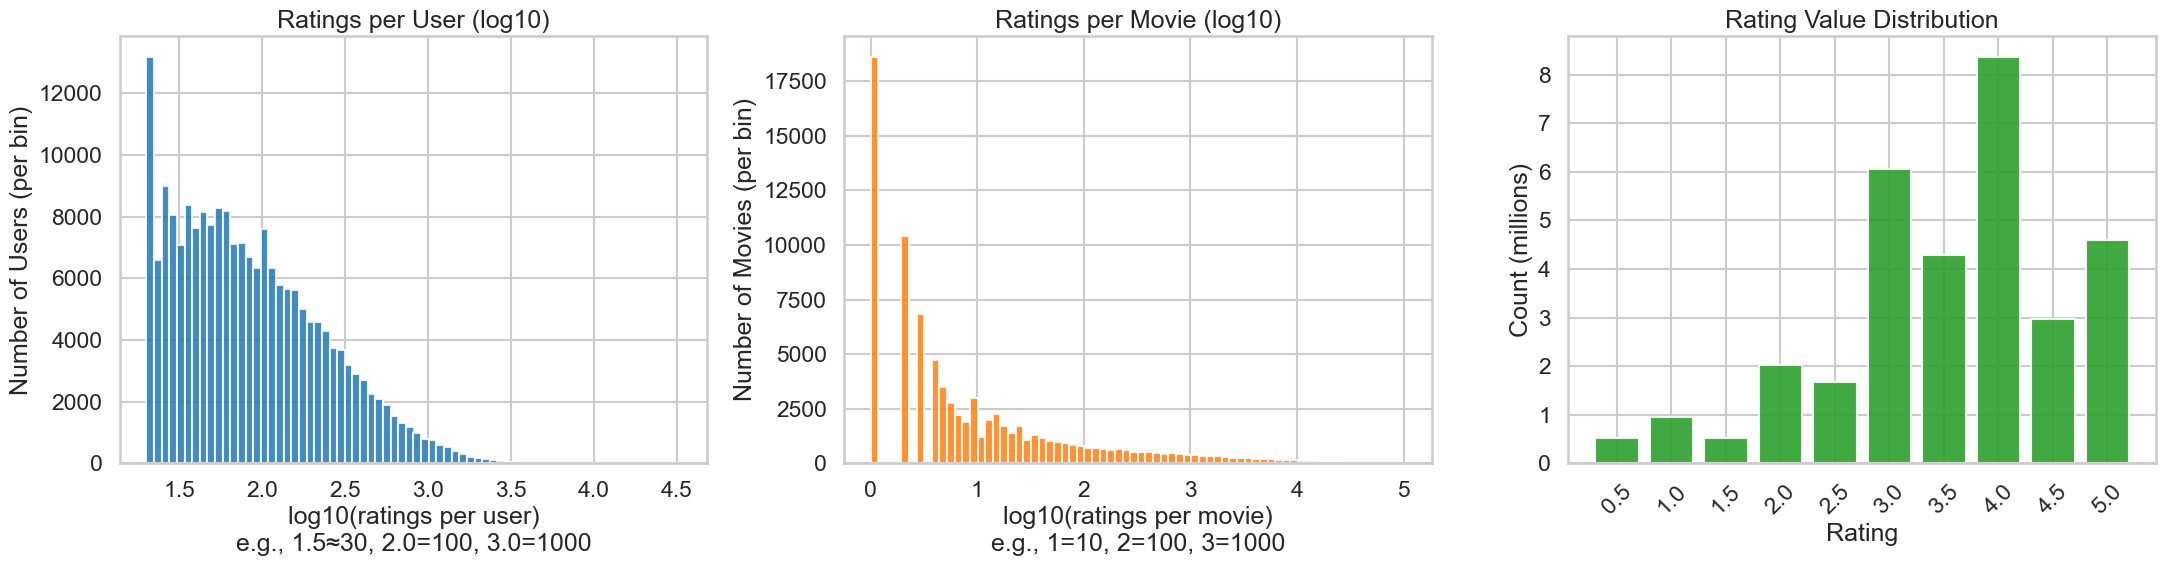

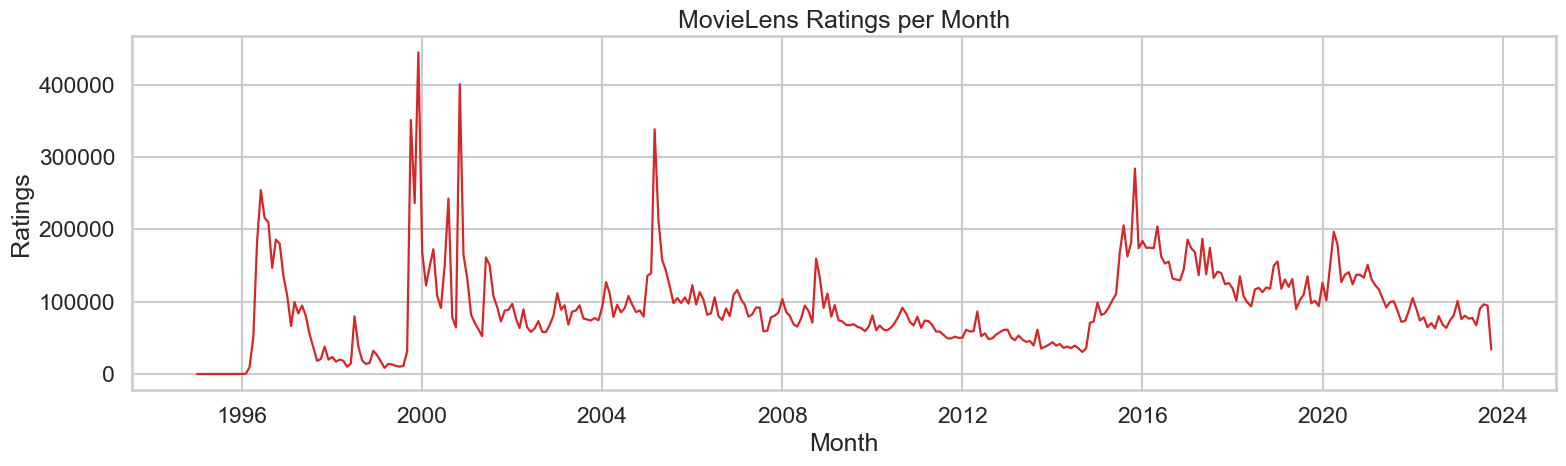

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

axes[0].hist(np.log10(ratings_per_user.values), bins=70, color='#1f77b4', alpha=0.85)
axes[0].set_title('Ratings per User (log10)')
axes[0].set_xlabel('log10(ratings per user)\ne.g., 1.5≈30, 2.0=100, 3.0=1000')
axes[0].set_ylabel('Number of Users (per bin)')

axes[1].hist(np.log10(ratings_per_movie.values), bins=70, color='#ff7f0e', alpha=0.85)
axes[1].set_title('Ratings per Movie (log10)')
axes[1].set_xlabel('log10(ratings per movie)\ne.g., 1=10, 2=100, 3=1000')
axes[1].set_ylabel('Number of Movies (per bin)')

rating_hist_sorted = rating_hist.sort_index()
axes[2].bar(rating_hist_sorted.index.astype(str), rating_hist_sorted.values / 1e6, color='#2ca02c', alpha=0.9)
axes[2].set_title('Rating Value Distribution')
axes[2].set_xlabel('Rating')
axes[2].set_ylabel('Count (millions)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 5))
monthly_ts = monthly_counts.copy()
monthly_ts.index = monthly_ts.index.to_timestamp()
plt.plot(monthly_ts.index, monthly_ts.values, color='#d62728', linewidth=1.6)
plt.title('MovieLens Ratings per Month')
plt.xlabel('Month')
plt.ylabel('Ratings')
plt.tight_layout()
plt.show()

### log scale in the histograms
- The log scale is used to better visualize data that has a wide range of values. For example, if most users give between 1 and 10 ratings, but a few power users give hundreds or thousands, a linear scale would make the histogram look very skewed and the details in the lower range would be hard to see. By using a log scale, we can spread out the values more evenly and see patterns that would otherwise be hidden.

- how it is calculated: log10(value + 1) is used to avoid taking log of zero. So if a user has given 0 ratings, it will be log10(0 + 1) = log10(1) = 0. If a user has given 10 ratings, it will be log10(10 + 1) ≈ 1.04. If a user has given 100 ratings, it will be log10(100 + 1) ≈ 2.00. This way, we can see the distribution of users with different numbers of ratings more clearly.

Non-empty tags: 2,000,049
Unique tag strings: 131,644


count
tag                      
sci-fi              11457
atmospheric         10088
action               9344
comedy               9275
funny                8088
surreal              7480
visually appealing   7253
based on a book      6733
twist ending         6600
romance              6229
dark comedy          6153
thought-provoking    6003
dystopia             5713
violence             5483
cinematography       5429
murder               5238
social commentary    5201
fantasy              5154
thriller             5050
quirky               4954

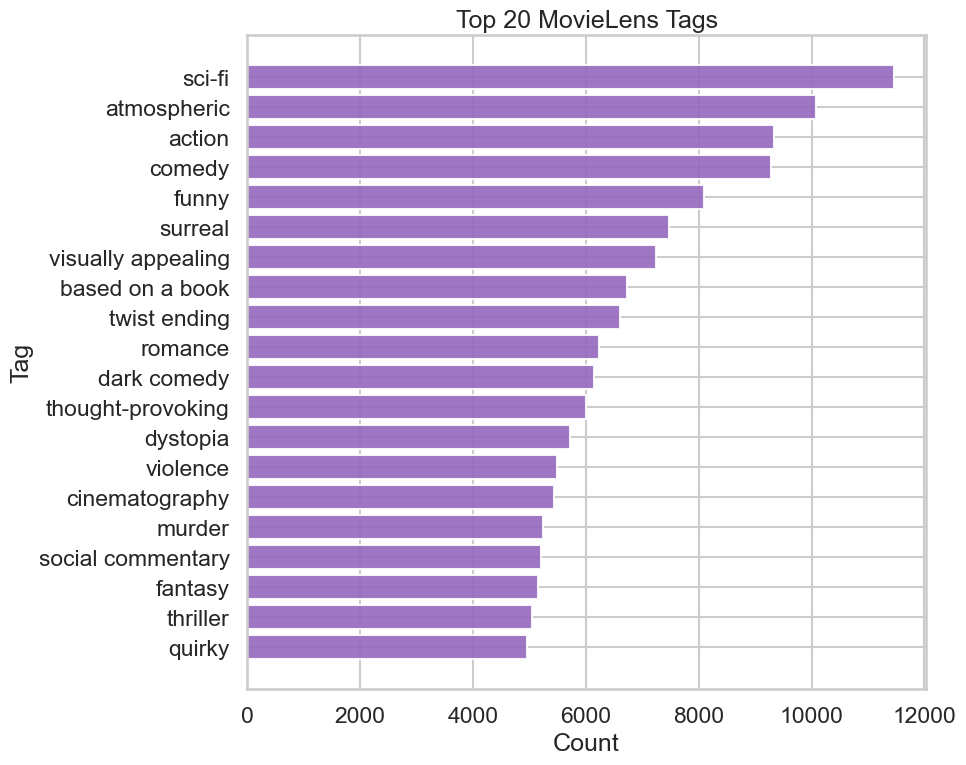

In [12]:
tags = pd.read_csv(
    TAGS_PATH,
    usecols=['movieId', 'tag'],
    dtype={'movieId': 'int32', 'tag': 'string'},
)

tags['tag'] = tags['tag'].fillna('').str.strip().str.lower()
tags = tags[tags['tag'] != '']

tag_counts = tags['tag'].value_counts()

print('Non-empty tags:', f"{len(tags):,}")
print('Unique tag strings:', f"{tag_counts.shape[0]:,}")

display(tag_counts.head(20).to_frame('count'))

plt.figure(figsize=(10, 8))
plot_top = tag_counts.head(20).sort_values(ascending=True)
plt.barh(plot_top.index, plot_top.values, color='#9467bd', alpha=0.9)
plt.title('Top 20 MovieLens Tags')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.tight_layout()
plt.show()

## 3) TMDB × MovieLens Coverage


In [13]:
links['tmdbId'] = pd.to_numeric(links['tmdbId'], errors='coerce').astype('Int64')

tmdb_lang_lookup = tmdb[['id', 'original_language']].dropna(subset=['id']).drop_duplicates('id').copy()
tmdb_lang_lookup['id'] = tmdb_lang_lookup['id'].astype('Int64')

tmdb_id_set = set(tmdb_lang_lookup['id'].dropna().astype('int64').tolist())
coverage_links = links.copy()
coverage_links['tmdb_exists_in_tmdb_v11'] = coverage_links['tmdbId'].isin(tmdb_id_set)

coverage_stats = pd.Series(
    {
        'links_rows': len(coverage_links),
        'links_with_tmdbId': int(coverage_links['tmdbId'].notna().sum()),
        'links_tmdbId_present_in_tmdb_v11': int(coverage_links['tmdb_exists_in_tmdb_v11'].sum()),
        'tmdb_link_coverage_pct': round(float(coverage_links['tmdb_exists_in_tmdb_v11'].mean() * 100), 2),
    },
    name='value',
)

display(coverage_stats.to_frame())

ratings_by_movie = ratings_per_movie.rename_axis('movieId').reset_index(name='ratings_count')
ratings_by_movie['movieId'] = ratings_by_movie['movieId'].astype('int32')

ml_tmdb = ratings_by_movie.merge(coverage_links[['movieId', 'tmdbId']], on='movieId', how='left')
ml_tmdb = ml_tmdb.merge(
    tmdb_lang_lookup.rename(columns={'id': 'tmdbId'}),
    on='tmdbId',
    how='left',
)
ml_tmdb['original_language'] = ml_tmdb['original_language'].fillna('unknown')

non_en = ml_tmdb[ml_tmdb['original_language'].isin(['unknown', 'en']) == False]
pct_non_en_ge10 = (
    float((non_en['ratings_count'] >= 10).mean() * 100)
    if len(non_en) > 0
    else np.nan
)

lang_agg = (
    ml_tmdb.groupby('original_language', dropna=False)
    .agg(
        rated_movies=('movieId', 'nunique'),
        total_ratings=('ratings_count', 'sum'),
        movies_ge10_ratings=('ratings_count', lambda s: int((s >= 10).sum())),
    )
    .sort_values('total_ratings', ascending=False)
)

print('Non-EN rated movies with >=10 ratings (%):', round(pct_non_en_ge10, 2) if pd.notna(pct_non_en_ge10) else 'N/A')
display(lang_agg.head(20))


value
links_rows                        87585.00
links_with_tmdbId                 87461.00
links_tmdbId_present_in_tmdb_v11  86493.00
tmdb_link_coverage_pct               98.75

Non-EN rated movies with >=10 ratings (%): 29.72


rated_movies  total_ratings  movies_ge10_ratings
original_language                                                  
en                        52165       29950702                22246
fr                         5021         432382                 1822
ja                         2910         368668                 1030
it                         2996         184396                  625
es                         2802         166560                  625
de                         2112         160535                  584
zh                         1030          94620                  305
ko                         1029          88613                  429
cn                          728          83888                  247
unknown                    1075          77897                  444
sv                          831          66589                  271
ru                         2134          66573                  727
pt                          880          42580                  170
da                          374          34399                  141
hi                         1213          34064                  538
fi                          649          13923                  248
no                          274          12502                   84
nl                          566          12380                  103
pl                          626          11807                  168
fa                          289          11234                  108

---
## 4) Target Variables & Rating Distribution Analysis

**Target variables for cross-cultural recommendation:**
- `vote_average` (TMDB) — global crowd-sourced rating (0–10 scale)
- `rating` (MovieLens) — individual user ratings (0.5–5.0 stars)
- `popularity` (TMDB) — TMDB popularity score (continuous, power-law distributed)
- `vote_count` (TMDB) — engagement proxy (how many TMDB users rated a movie)

**Why so many missing values in TMDB?** The TMDB v11 dataset has 1.37M entries — it includes *every* film globally registered on TMDB, including obscure regional productions, student films, and unreleased projects. Most of these are stubs with only a title/ID. Keywords (75% missing) are community-curated; genres and overviews require manual entry. This is expected for a crowd-sourced database at this scale.

**Reading log-scale histograms:** The x-axis shows log10 of the value. E.g., `log10(ratings/user) = 2.0` means the user gave $10^2 = 100$ ratings. The y-axis shows *how many users/movies fall in that histogram bin*,  NOT the total count.

TMDB total movies: 1,368,726
TMDB movies with ≥1 vote: 357,345 (26.1%)
TMDB movies with vote_average=0 (no votes): 1,011,660


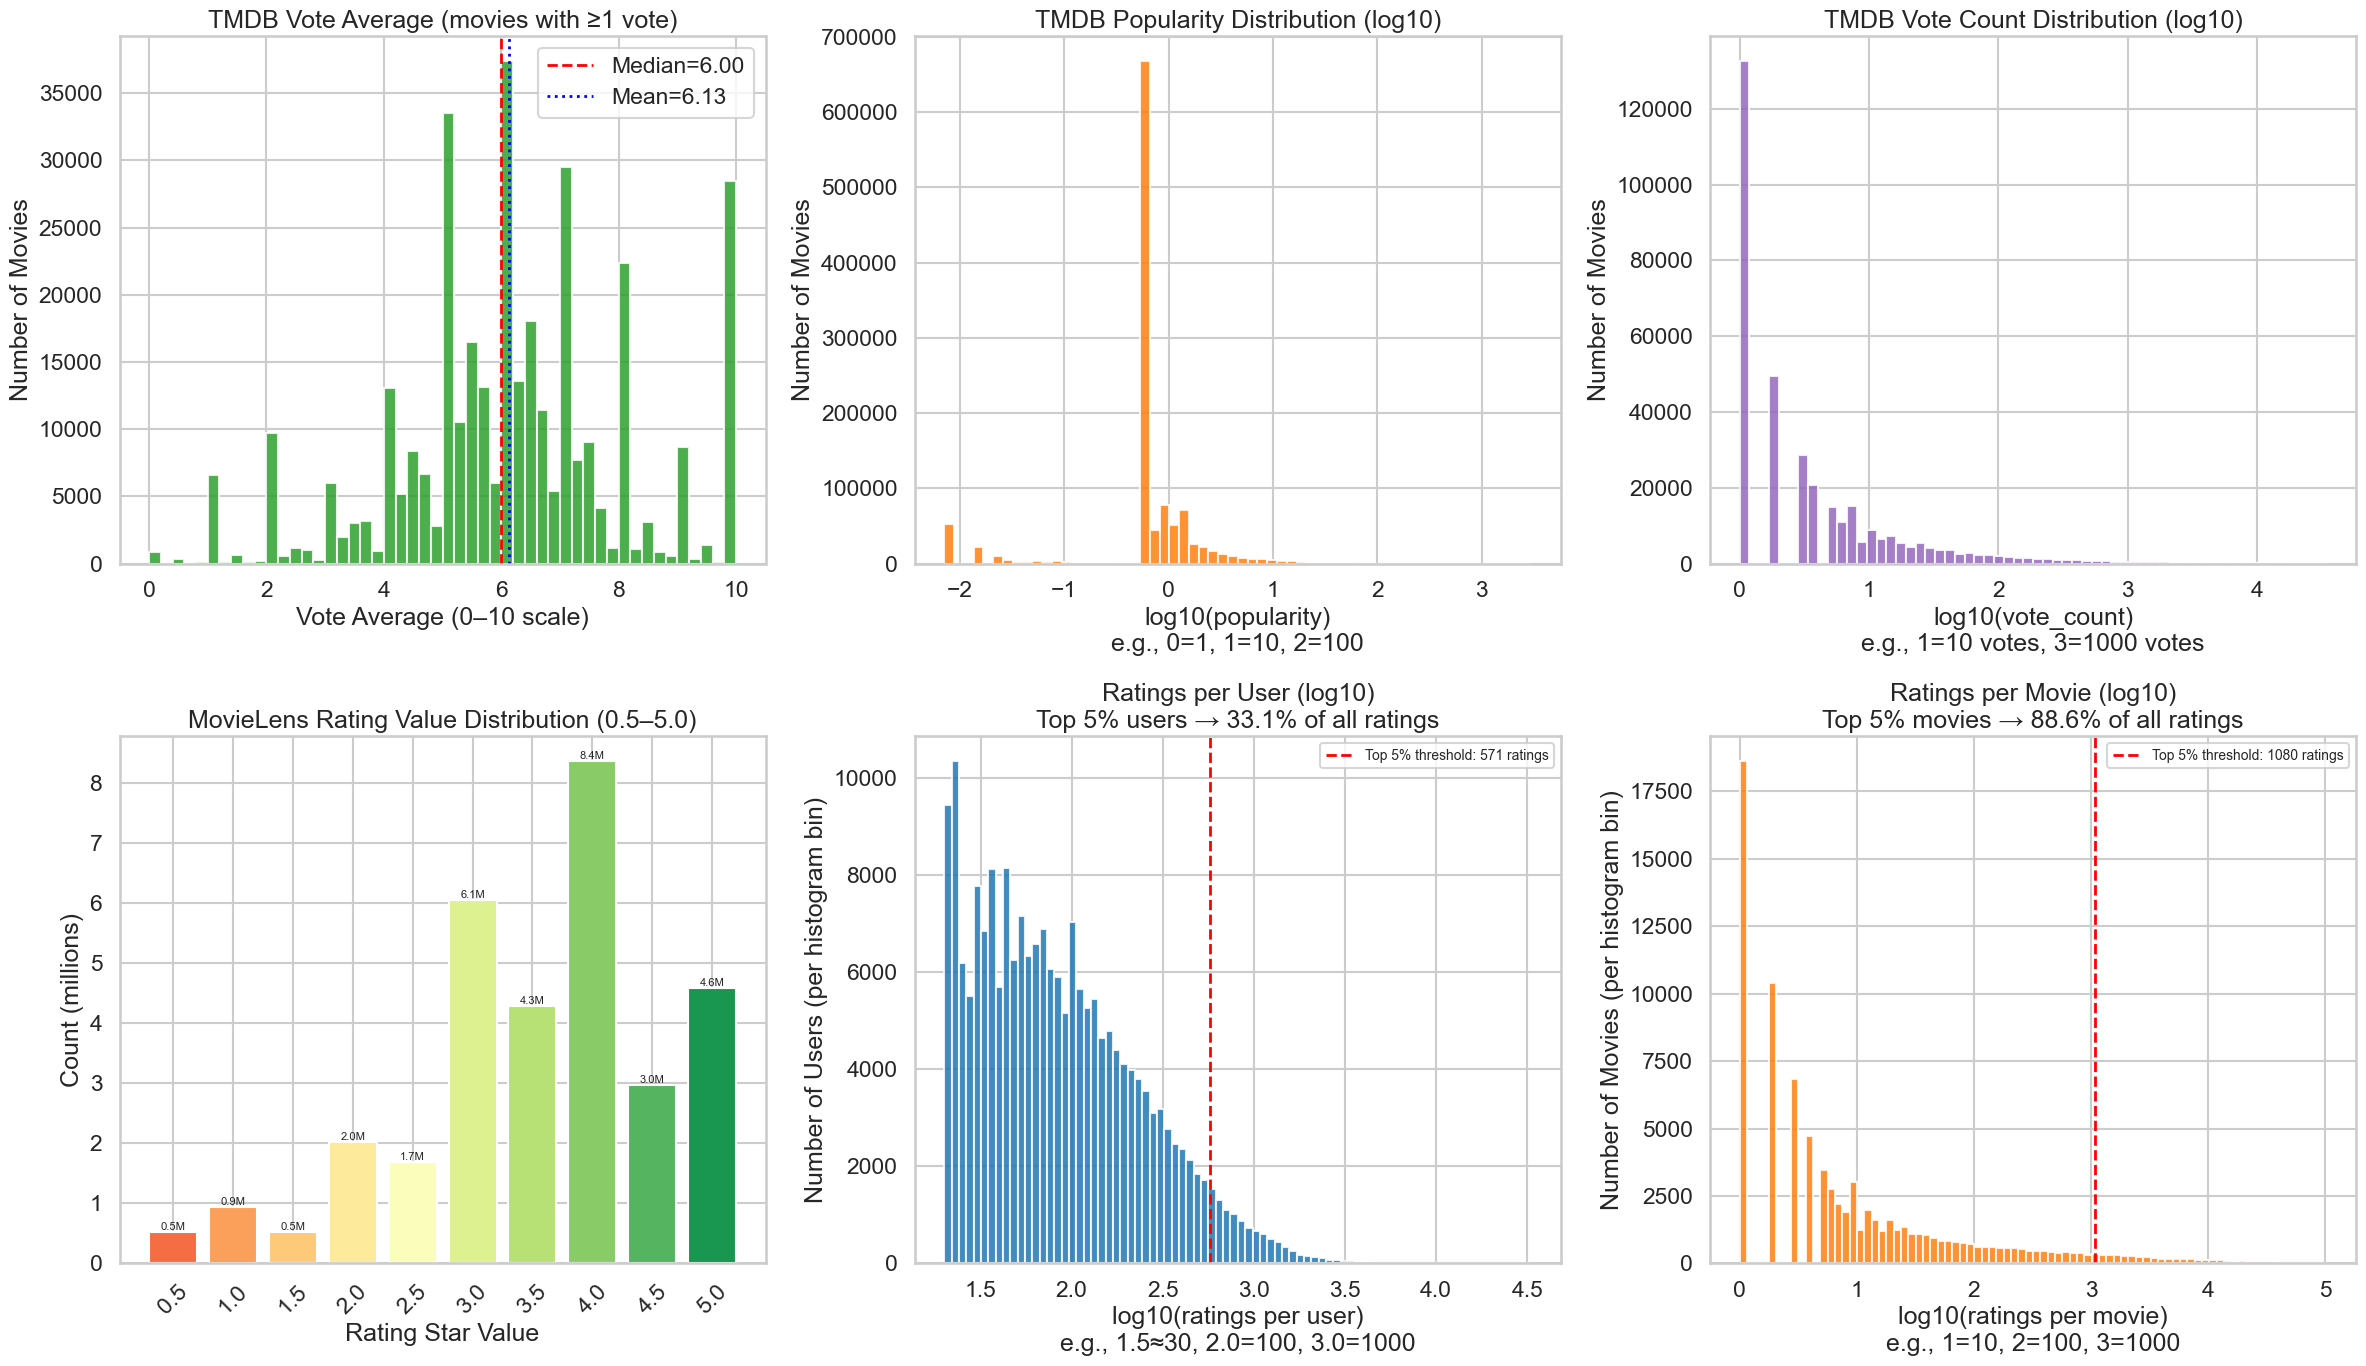

In [14]:
# Target Variable Distributions

# on TMDB data: ~1M movies have vote_average=0 (never rated on TMDB).
# We show BOTH the full distribution and the filtered (vote_count≥1) version.

tmdb_voted = tmdb[tmdb['vote_count'].fillna(0) >= 1]  # Movies that actually have votes
print(f'TMDB total movies: {len(tmdb):,}')
print(f'TMDB movies with ≥1 vote: {len(tmdb_voted):,} ({len(tmdb_voted)/len(tmdb)*100:.1f}%)')
print(f'TMDB movies with vote_average=0 (no votes): {(tmdb["vote_average"]==0).sum():,}')

fig, axes = plt.subplots(2, 3, figsize=(24, 14))

# 1. TMDB vote_average — FILTERED to movies with at least 1 vote
votes_filtered = tmdb_voted['vote_average'].dropna()
axes[0, 0].hist(votes_filtered, bins=50, color='#2ca02c', alpha=0.85, edgecolor='white')
axes[0, 0].axvline(votes_filtered.median(), color='red', ls='--', lw=2,
                    label=f'Median={votes_filtered.median():.2f}')
axes[0, 0].axvline(votes_filtered.mean(), color='blue', ls=':', lw=2,
                    label=f'Mean={votes_filtered.mean():.2f}')
axes[0, 0].set_title('TMDB Vote Average (movies with ≥1 vote)')
axes[0, 0].set_xlabel('Vote Average (0–10 scale)')
axes[0, 0].set_ylabel('Number of Movies')
axes[0, 0].legend()

# 2. TMDB popularity (log scale) — only nonzero
pop_nonzero = tmdb.loc[tmdb['popularity'].fillna(0) > 0, 'popularity']
axes[0, 1].hist(np.log10(pop_nonzero), bins=60, color='#ff7f0e', alpha=0.85, edgecolor='white')
axes[0, 1].set_title('TMDB Popularity Distribution (log10)')
axes[0, 1].set_xlabel('log10(popularity)\ne.g., 0=1, 1=10, 2=100')
axes[0, 1].set_ylabel('Number of Movies')

# 3. TMDB vote_count (log scale)
vc_nonzero = tmdb.loc[tmdb['vote_count'].fillna(0) > 0, 'vote_count']
axes[0, 2].hist(np.log10(vc_nonzero), bins=60, color='#9467bd', alpha=0.85, edgecolor='white')
axes[0, 2].set_title('TMDB Vote Count Distribution (log10)')
axes[0, 2].set_xlabel('log10(vote_count)\ne.g., 1=10 votes, 3=1000 votes')
axes[0, 2].set_ylabel('Number of Movies')

# 4. MovieLens rating value distribution (0.5–5.0 star breakdown)
rating_hist_sorted = rating_hist.sort_index()
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(rating_hist_sorted)))
bars = axes[1, 0].bar(rating_hist_sorted.index.astype(str), rating_hist_sorted.values / 1e6, color=colors, edgecolor='white')
for bar, val in zip(bars, rating_hist_sorted.values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{val/1e6:.1f}M',
                     ha='center', va='bottom', fontsize=8)
axes[1, 0].set_title('MovieLens Rating Value Distribution (0.5–5.0)')
axes[1, 0].set_xlabel('Rating Star Value')
axes[1, 0].set_ylabel('Count (millions)')
axes[1, 0].tick_params(axis='x', rotation=45)

# 5. Ratings per user (log-scale) with power-law annotation
# Y-axis = number of users in each histogram bin
# X-axis = log10 of how many ratings that user gave (e.g. 2.0 = 100 ratings)
axes[1, 1].hist(np.log10(ratings_per_user.values), bins=80, color='#1f77b4', alpha=0.85, edgecolor='white')
top5_threshold = ratings_per_user.quantile(0.95)
top5_share = ratings_per_user[ratings_per_user >= top5_threshold].sum() / ratings_per_user.sum() * 100
axes[1, 1].axvline(np.log10(top5_threshold), color='red', ls='--', lw=2,
                    label=f'Top 5% threshold: {int(top5_threshold)} ratings')
axes[1, 1].set_title(f'Ratings per User (log10)\nTop 5% users → {top5_share:.1f}% of all ratings')
axes[1, 1].set_xlabel('log10(ratings per user)\ne.g., 1.5≈30, 2.0=100, 3.0=1000')
axes[1, 1].set_ylabel('Number of Users (per histogram bin)')
axes[1, 1].legend(fontsize=10)

# 6. Ratings per movie (log-scale)
axes[1, 2].hist(np.log10(ratings_per_movie.values), bins=80, color='#ff7f0e', alpha=0.85, edgecolor='white')

top5_movie_threshold = ratings_per_movie.quantile(0.95)
top5_movie_share = ratings_per_movie[ratings_per_movie >= top5_movie_threshold].sum() / ratings_per_movie.sum() * 100

axes[1, 2].axvline(
    np.log10(top5_movie_threshold),
    color='red',
    ls='--',
    lw=2,
    label=f'Top 5% threshold: {int(top5_movie_threshold)} ratings'
)
axes[1, 2].set_title(f'Ratings per Movie (log10)\nTop 5% movies → {top5_movie_share:.1f}% of all ratings')
axes[1, 2].set_xlabel('log10(ratings per movie)\ne.g., 1=10, 2=100, 3=1000')
axes[1, 2].set_ylabel('Number of Movies (per histogram bin)')
axes[1, 2].legend(fontsize=10)

plt.tight_layout()
plt.show()

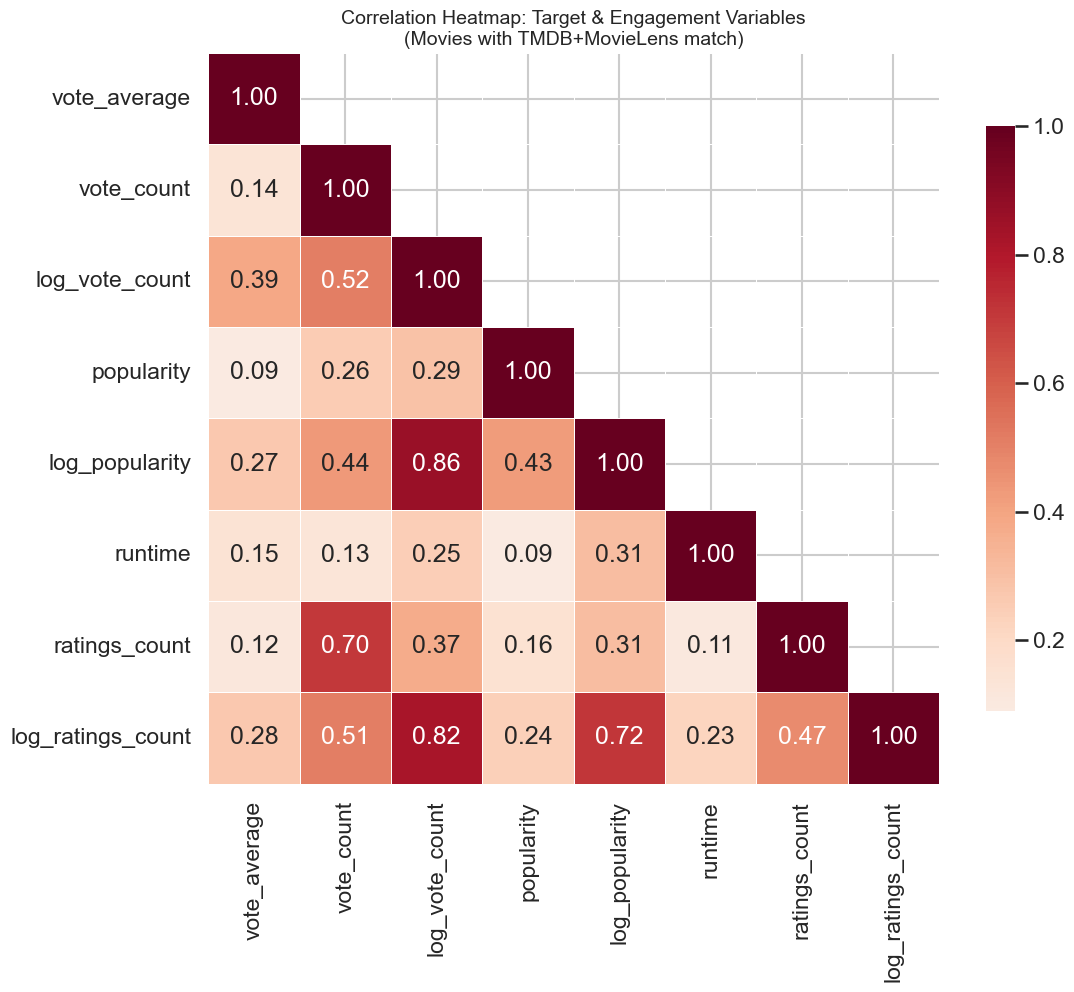


Movies in correlation analysis: 83,357
Strongest positive correlation: ML ratings_count ↔ TMDB vote_count = 0.705


In [15]:
# Correlation Heatmap of Target Variables

# per-movie feature matrix by merging TMDB features with ML rating stats
target_df = ml_tmdb[['movieId', 'tmdbId', 'ratings_count']].copy()
target_df = target_df.merge(
    tmdb[['id', 'vote_average', 'vote_count', 'popularity', 'runtime']].rename(columns={'id': 'tmdbId'}),
    on='tmdbId', how='inner'
)

# Compute avg ML rating per movie; use TMDB vote_average as proxy alongside ML engagement metrics
target_df = target_df.dropna(subset=['vote_average', 'vote_count', 'popularity'])
target_df['log_ratings_count'] = np.log1p(target_df['ratings_count'])
target_df['log_vote_count'] = np.log1p(target_df['vote_count'])
target_df['log_popularity'] = np.log1p(target_df['popularity'])

corr_cols = ['vote_average', 'vote_count', 'log_vote_count', 'popularity',
             'log_popularity', 'runtime', 'ratings_count', 'log_ratings_count']
corr_matrix = target_df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, square=True, linewidths=0.5, ax=ax,
            cbar_kws={'shrink': 0.8})
ax.set_title('Correlation Heatmap: Target & Engagement Variables\n(Movies with TMDB+MovieLens match)', fontsize=14)
plt.tight_layout()
plt.show()

print(f'\nMovies in correlation analysis: {len(target_df):,}')
print(f'Strongest positive correlation: ML ratings_count ↔ TMDB vote_count = {corr_matrix.loc["ratings_count","vote_count"]:.3f}')

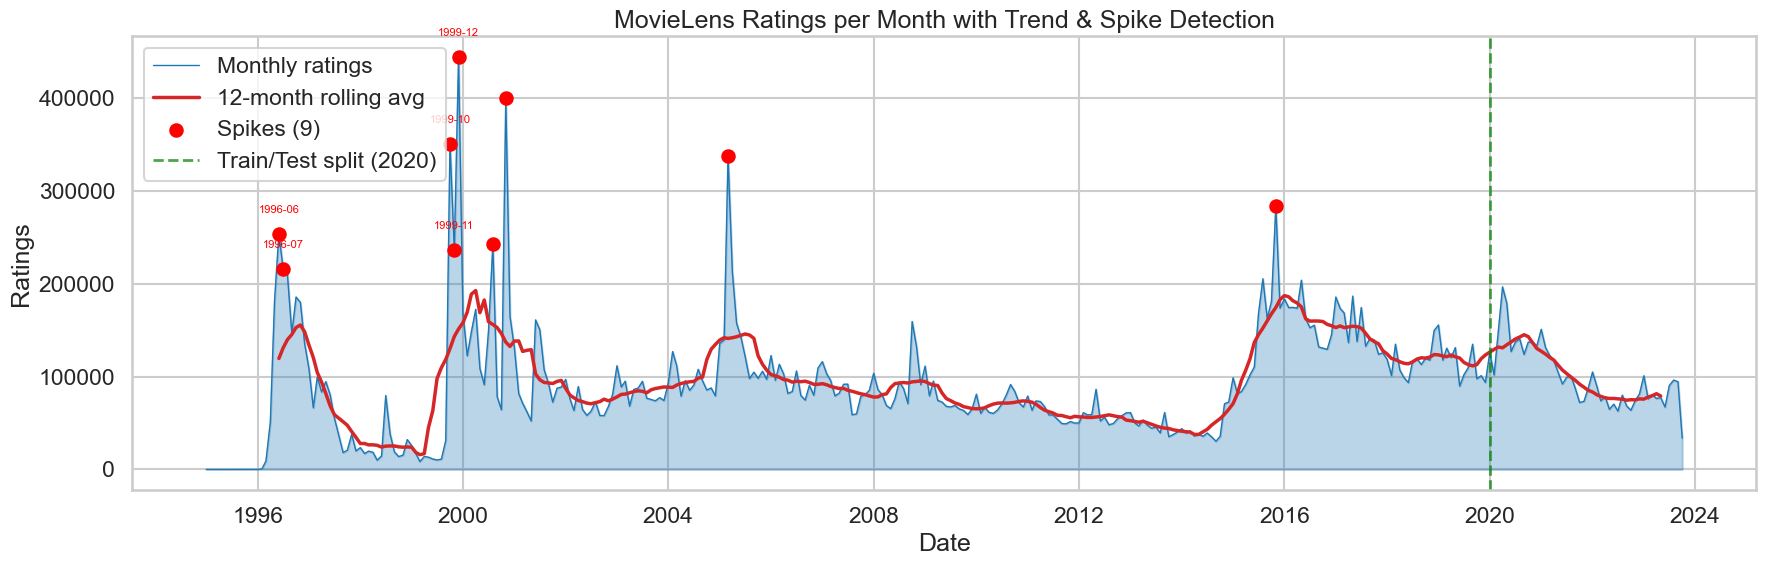

Total spikes detected: 9
Top spike months:
  1999-12: 444,681 ratings
  2000-11: 400,851 ratings
  1999-10: 351,183 ratings
  2005-03: 338,383 ratings
  2015-11: 284,051 ratings


In [16]:
#  Ratings per Month with Spike

monthly_ts = monthly_counts.copy()
monthly_ts.index = monthly_ts.index.to_timestamp()

# Rolling average for trend
rolling_avg = monthly_ts.rolling(window=12, center=True).mean()

# Detect spikes (> 2 std above rolling mean)
residuals = monthly_ts - rolling_avg
spike_threshold = residuals.mean() + 2 * residuals.std()
spikes = monthly_ts[residuals > spike_threshold]

fig, ax = plt.subplots(figsize=(18, 6))
ax.fill_between(monthly_ts.index, monthly_ts.values, alpha=0.3, color='#1f77b4')
ax.plot(monthly_ts.index, monthly_ts.values, color='#1f77b4', linewidth=1, label='Monthly ratings')
ax.plot(rolling_avg.index, rolling_avg.values, color='#d62728', linewidth=2.5, label='12-month rolling avg')

if len(spikes) > 0:
    ax.scatter(spikes.index, spikes.values, color='red', s=80, zorder=5, label=f'Spikes ({len(spikes)})')
    for date, val in spikes.head(5).items():
        ax.annotate(f'{date:%Y-%m}', (date, val), textcoords='offset points',
                    xytext=(0, 15), fontsize=8, ha='center', color='red')

# Mark potential train/test split
split_date = pd.Timestamp('2020-01-01')
ax.axvline(split_date, color='green', ls='--', lw=2, alpha=0.7, label='Train/Test split (2020)')

ax.set_title('MovieLens Ratings per Month with Trend & Spike Detection')
ax.set_xlabel('Date')
ax.set_ylabel('Ratings')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

print(f'Total spikes detected: {len(spikes)}')
if len(spikes) > 0:
    print('Top spike months:')
    for date, val in spikes.nlargest(5).items():
        print(f'  {date:%Y-%m}: {val:,.0f} ratings')

---
## 5) Language & Cultural Coverage

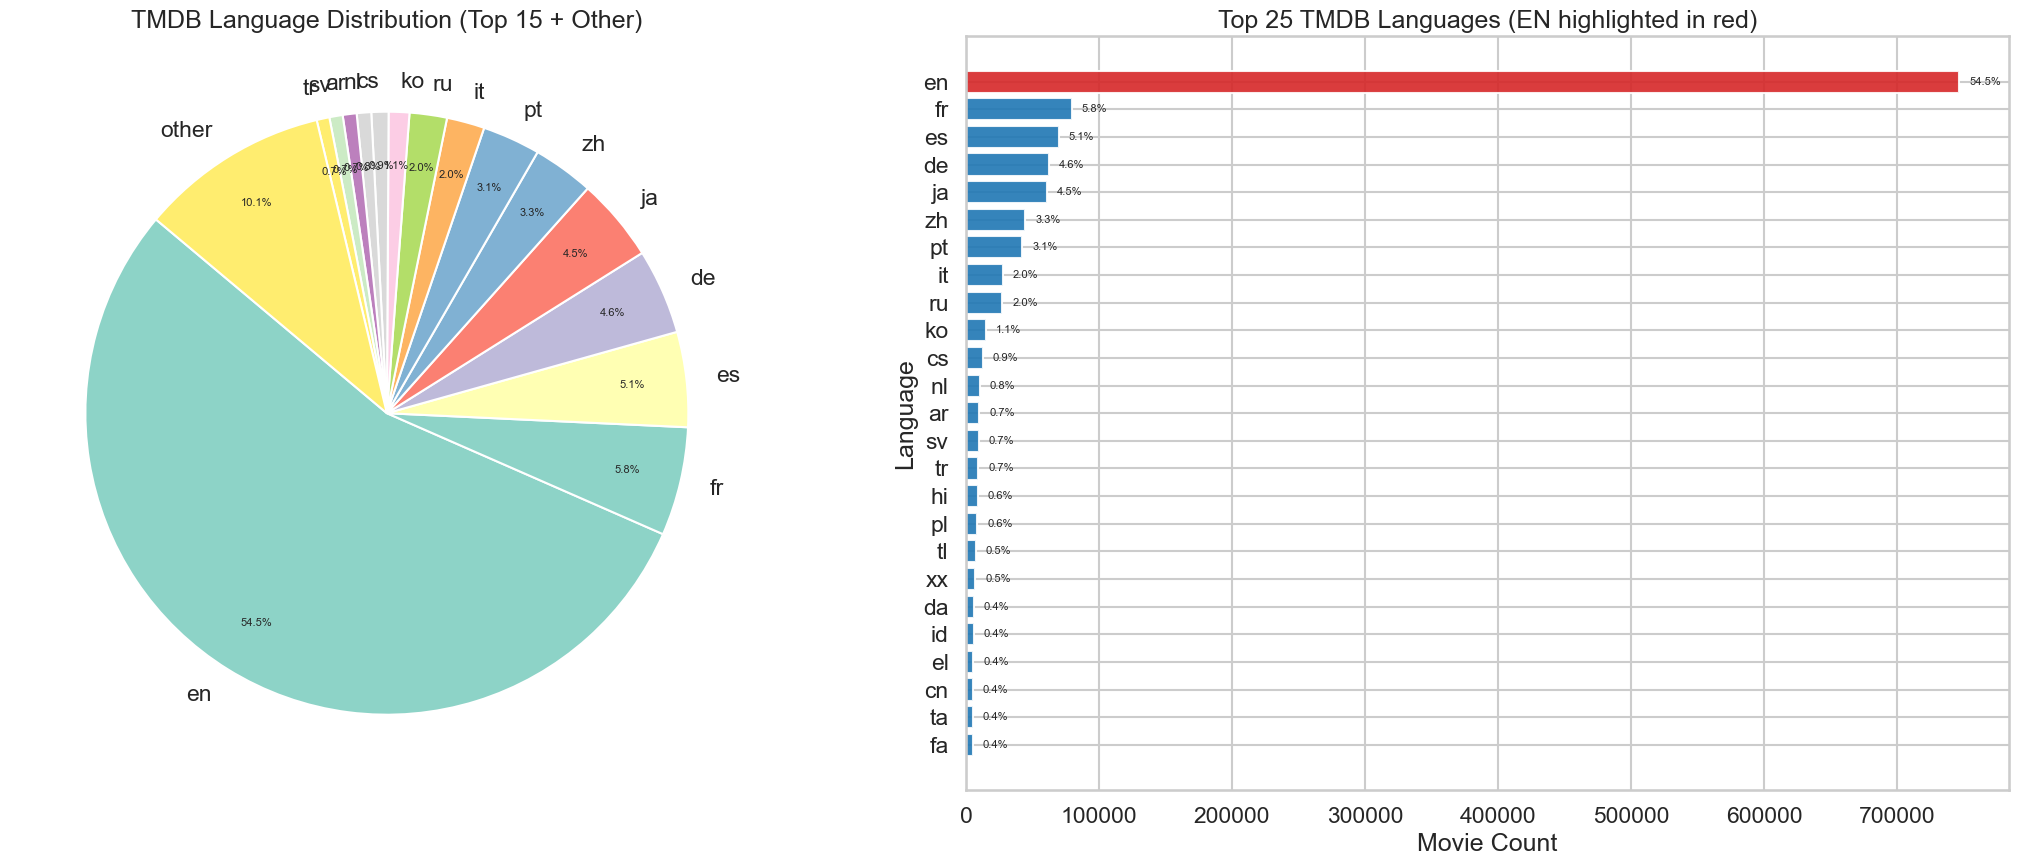


English movies: 746,505 (54.5%)
Non-English movies: 622,221 (45.5%)
Total unique languages: 177


In [17]:
#  Language Distribution in TMDB Catalog

lang_counts = tmdb['original_language'].value_counts()
top_n = 15
top_langs = lang_counts.head(top_n)
other_count = lang_counts.iloc[top_n:].sum()
pie_data = pd.concat([top_langs, pd.Series({'other': other_count})])

fig, axes = plt.subplots(1, 2, figsize=(22, 9))

# Pie chart
wedges, texts, autotexts = axes[0].pie(
    pie_data.values, labels=pie_data.index, autopct='%1.1f%%',
    pctdistance=0.82, startangle=140,
    colors=plt.cm.Set3(np.linspace(0, 1, len(pie_data))),
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)
for t in autotexts:
    t.set_fontsize(8)
axes[0].set_title(f'TMDB Language Distribution (Top {top_n} + Other)')

# Bar chart
bar_data = lang_counts.head(25).sort_values(ascending=True)
colors_bar = ['#d62728' if lang == 'en' else '#1f77b4' for lang in bar_data.index]
axes[1].barh(bar_data.index, bar_data.values, color=colors_bar, alpha=0.9, edgecolor='white')
axes[1].set_title('Top 25 TMDB Languages (EN highlighted in red)')
axes[1].set_xlabel('Movie Count')
axes[1].set_ylabel('Language')

# Add percentage labels
for i, (lang, count) in enumerate(bar_data.items()):
    axes[1].text(count + lang_counts.max() * 0.01, i, f'{count/len(tmdb)*100:.1f}%', va='center', fontsize=8)

plt.tight_layout()
plt.show()

en_pct = lang_counts.get('en', 0) / len(tmdb) * 100
print(f'\nEnglish movies: {lang_counts.get("en", 0):,} ({en_pct:.1f}%)')
print(f'Non-English movies: {len(tmdb) - lang_counts.get("en", 0):,} ({100 - en_pct:.1f}%)')
print(f'Total unique languages: {tmdb["original_language"].nunique()}')

num_movies  total_ratings  avg_ratings_per_movie  \
original_language                                                     
en                      52165       29950702             574.153206   
fr                       5021         432382              86.114718   
ja                       2910         368668             126.690034   
es                       2802         166560              59.443255   
de                       2112         160535              76.010890   
zh                       1030          94620              91.864078   
ko                       1029          88613              86.115646   
hi                       1213          34064              28.082440   
te                        259           2607              10.065637   
ta                        421           2581               6.130641   

                   median_ratings_per_movie  movies_ge10  movies_ge100  \
original_language                                                        
en                                      6.0        22246         10274   
fr                                      5.0         1822           464   
ja                                      4.0         1030           271   
es                                      3.0          625           122   
de                                      3.0          584           120   
zh                                      4.0          305            62   
ko                                      7.0          429            60   
hi                                      7.0          538            55   
te                                      4.0           66             3   
ta                                      2.0           86             1   

                   pct_ge10  pct_ge100  
original_language                       
en                     42.6       19.7  
fr                     36.3        9.2  
ja                     35.4        9.3  
es                     22.3        4.4  
de                     27.7        5.7  
zh                     29.6        6.0  
ko                     41.7        5.8  
hi                     44.4        4.5  
te                     25.5        1.2  
ta                     20.4        0.2

/var/folders/lq/r8qjzl2x10b2vksfq2gq9m080000gn/T/ipykernel_21232/645114814.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(box_data, labels=box_labels, patch_artist=True, showfliers=False)


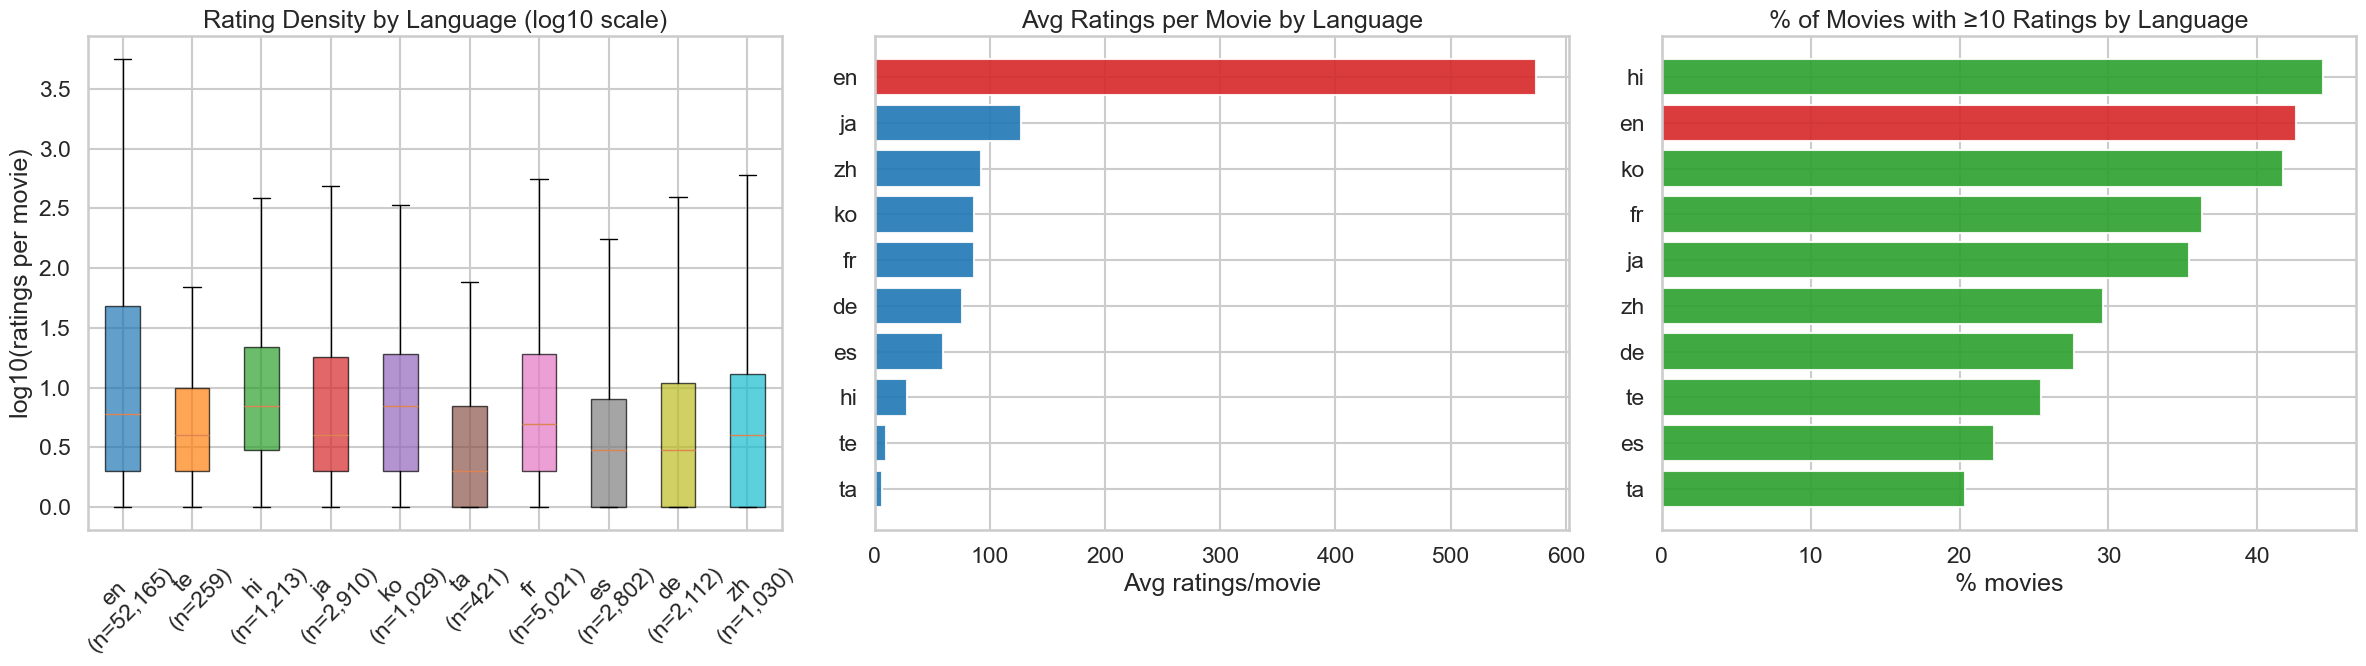


═══ CROSS-CULTURAL FEASIBILITY ═══
TE: 259 movies, 26% with ≥10 ratings, avg=10 ratings/movie
HI: 1213 movies, 44% with ≥10 ratings, avg=28 ratings/movie
JA: 2910 movies, 35% with ≥10 ratings, avg=127 ratings/movie
KO: 1029 movies, 42% with ≥10 ratings, avg=86 ratings/movie
TA: 421 movies, 20% with ≥10 ratings, avg=6 ratings/movie


In [18]:
# Rating Density by Language: EN vs TE/HI/JA/KO/TA

focus_langs = ['en', 'te', 'hi', 'ja', 'ko', 'ta', 'fr', 'es', 'de', 'zh']
lang_rating_stats = (
    ml_tmdb[ml_tmdb['original_language'].isin(focus_langs)]
    .groupby('original_language')
    .agg(
        num_movies=('movieId', 'nunique'),
        total_ratings=('ratings_count', 'sum'),
        avg_ratings_per_movie=('ratings_count', 'mean'),
        median_ratings_per_movie=('ratings_count', 'median'),
        movies_ge10=('ratings_count', lambda s: int((s >= 10).sum())),
        movies_ge100=('ratings_count', lambda s: int((s >= 100).sum())),
    )
    .sort_values('total_ratings', ascending=False)
)
lang_rating_stats['pct_ge10'] = (lang_rating_stats['movies_ge10'] / lang_rating_stats['num_movies'] * 100).round(1)
lang_rating_stats['pct_ge100'] = (lang_rating_stats['movies_ge100'] / lang_rating_stats['num_movies'] * 100).round(1)

display(lang_rating_stats)

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Box plot of ratings per movie by language
box_data = []
box_labels = []
for lang in focus_langs:
    subset = ml_tmdb.loc[ml_tmdb['original_language'] == lang, 'ratings_count']
    if len(subset) > 0:
        box_data.append(np.log10(subset.clip(lower=1).values))
        box_labels.append(f'{lang}\n(n={len(subset):,})')

bp = axes[0].boxplot(box_data, labels=box_labels, patch_artist=True, showfliers=False)
for patch, color in zip(bp['boxes'], plt.cm.tab10(np.linspace(0, 1, len(box_data)))):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].set_title('Rating Density by Language (log10 scale)')
axes[0].set_ylabel('log10(ratings per movie)')
axes[0].tick_params(axis='x', rotation=45)

# Bar: avg ratings per movie by language
sorted_stats = lang_rating_stats.sort_values('avg_ratings_per_movie', ascending=True)
colors = ['#d62728' if l == 'en' else '#1f77b4' for l in sorted_stats.index]
axes[1].barh(sorted_stats.index, sorted_stats['avg_ratings_per_movie'], color=colors, alpha=0.9)
axes[1].set_title('Avg Ratings per Movie by Language')
axes[1].set_xlabel('Avg ratings/movie')

# Bar: % of movies with ≥10 ratings
sorted_ge10 = lang_rating_stats.sort_values('pct_ge10', ascending=True)
colors2 = ['#d62728' if l == 'en' else '#2ca02c' for l in sorted_ge10.index]
axes[2].barh(sorted_ge10.index, sorted_ge10['pct_ge10'], color=colors2, alpha=0.9)
axes[2].set_title('% of Movies with ≥10 Ratings by Language')
axes[2].set_xlabel('% movies')

plt.tight_layout()
plt.show()

print('\n═══ CROSS-CULTURAL FEASIBILITY ═══')
for lang in ['te', 'hi', 'ja', 'ko', 'ta']:
    if lang in lang_rating_stats.index:
        row = lang_rating_stats.loc[lang]
        print(f'{lang.upper()}: {int(row["num_movies"])} movies, {row["pct_ge10"]:.0f}% with ≥10 ratings, avg={row["avg_ratings_per_movie"]:.0f} ratings/movie')

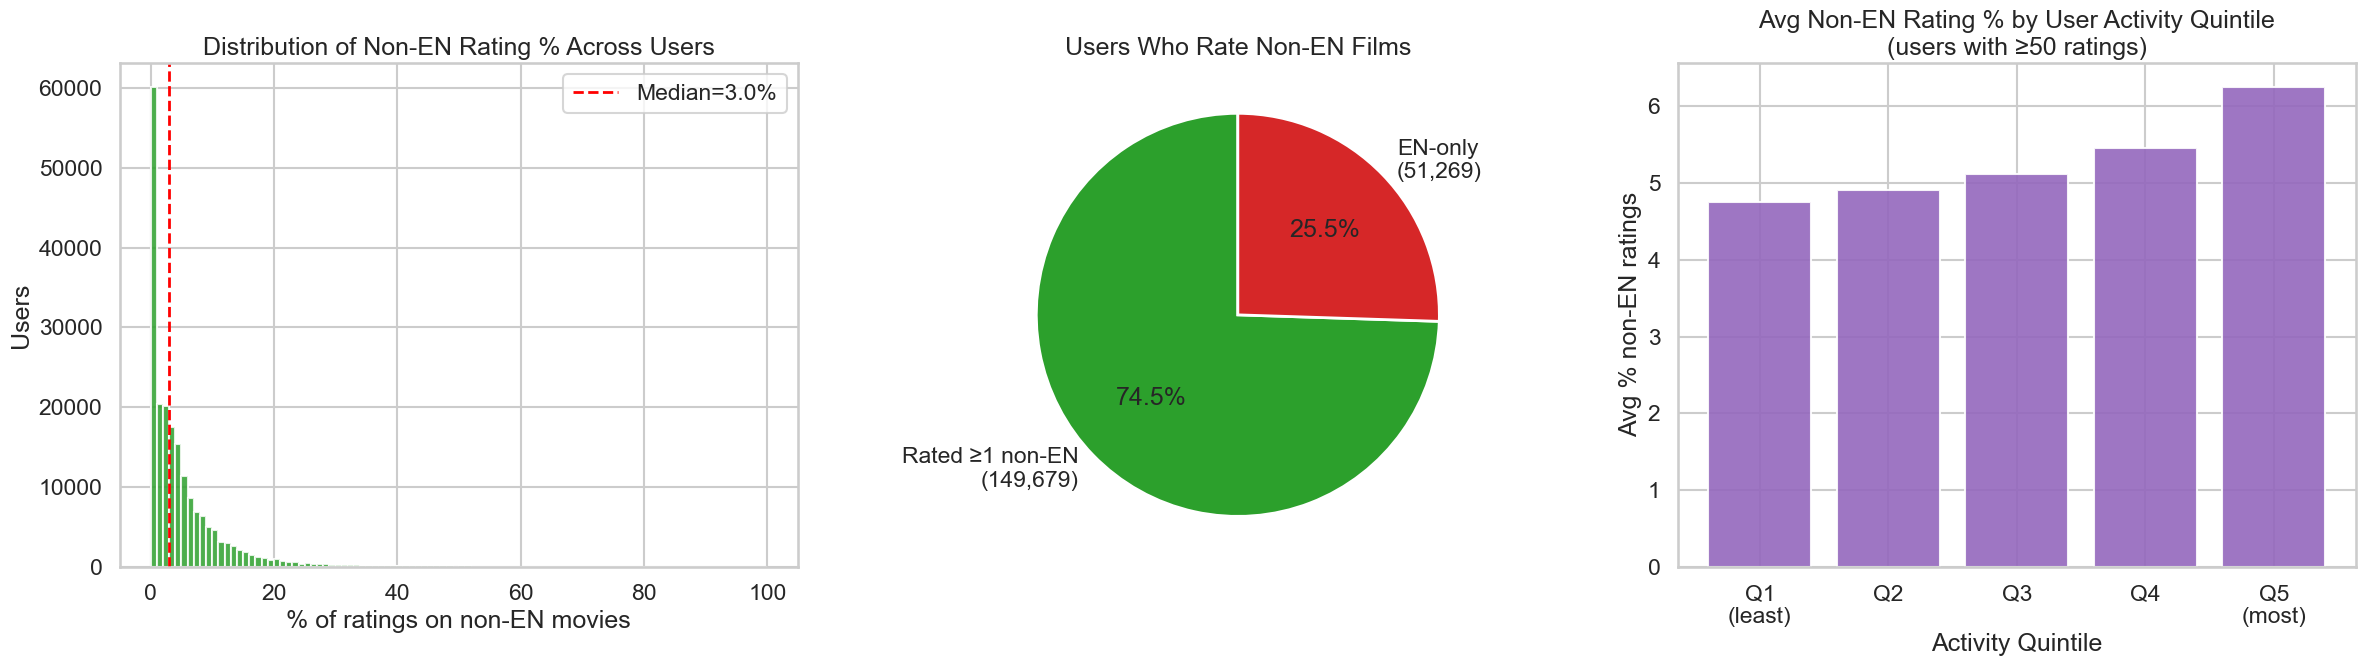


Users who rated ≥1 non-EN film: 149,679 (74.5%)
Median non-EN rating %: 2.98%
Mean non-EN rating %: 4.94%


In [19]:
#  Cross-Language Rating Matrix: Do EN Users Rate Non-EN Films

# We can't directly identify user language, but we can proxy:
# Users who rate ≥80% EN movies → "EN-dominant users"
# Check what % of their ratings go to non-EN films

# Build user–language rating proportions from chunked data
user_lang_counts = pd.Series(dtype='int64')
user_total_counts = pd.Series(dtype='int64')

# Movie-language lookup
movie_lang = ml_tmdb[['movieId', 'original_language']].drop_duplicates('movieId')
movie_lang_dict = dict(zip(movie_lang['movieId'], movie_lang['original_language']))

# Re-read ratings in chunks for user-language analysis
for chunk in pd.read_csv(
    RATINGS_PATH,
    usecols=['userId', 'movieId'],
    dtype={'userId': 'int32', 'movieId': 'int32'},
    chunksize=5_000_000,
):
    chunk['lang'] = chunk['movieId'].map(movie_lang_dict).fillna('unknown')
    user_total_counts = user_total_counts.add(chunk['userId'].value_counts(), fill_value=0)

    non_en_chunk = chunk[~chunk['lang'].isin(['en', 'unknown'])]
    if len(non_en_chunk) > 0:
        user_lang_counts = user_lang_counts.add(non_en_chunk['userId'].value_counts(), fill_value=0)

user_total_counts = user_total_counts.astype('int64')
user_lang_counts = user_lang_counts.reindex(user_total_counts.index, fill_value=0).astype('int64')
user_non_en_pct = (user_lang_counts / user_total_counts * 100).fillna(0)

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# 1. Distribution of non-EN rating percentage across all users
axes[0].hist(user_non_en_pct.values, bins=100, color='#2ca02c', alpha=0.85, edgecolor='white')
axes[0].set_title('Distribution of Non-EN Rating % Across Users')
axes[0].set_xlabel('% of ratings on non-EN movies')
axes[0].set_ylabel('Users')
axes[0].axvline(user_non_en_pct.median(), color='red', ls='--', lw=2,
                label=f'Median={user_non_en_pct.median():.1f}%')
axes[0].legend()

# 2. What fraction of users have rated at least 1 non-EN film?
users_any_non_en = (user_lang_counts > 0).sum()
users_no_non_en = (user_lang_counts == 0).sum()
axes[1].pie([users_any_non_en, users_no_non_en],
            labels=[f'Rated ≥1 non-EN\n({users_any_non_en:,})', f'EN-only\n({users_no_non_en:,})'],
            autopct='%1.1f%%', colors=['#2ca02c', '#d62728'],
            wedgeprops={'edgecolor': 'white', 'linewidth': 2}, startangle=90)
axes[1].set_title('Users Who Rate Non-EN Films')

# 3. Among users with ≥50 ratings: non-EN % by user activity quantile
active_users = user_total_counts[user_total_counts >= 50]
active_non_en_pct = user_non_en_pct.reindex(active_users.index)
activity_quantiles = pd.qcut(active_users, q=5, labels=['Q1\n(least)', 'Q2', 'Q3', 'Q4', 'Q5\n(most)'])
q_non_en = active_non_en_pct.groupby(activity_quantiles).mean()

axes[2].bar(q_non_en.index.astype(str), q_non_en.values, color='#9467bd', alpha=0.9, edgecolor='white')
axes[2].set_title('Avg Non-EN Rating % by User Activity Quintile\n(users with ≥50 ratings)')
axes[2].set_xlabel('Activity Quintile')
axes[2].set_ylabel('Avg % non-EN ratings')

plt.tight_layout()
plt.show()

print(f'\nUsers who rated ≥1 non-EN film: {users_any_non_en:,} ({users_any_non_en/(users_any_non_en+users_no_non_en)*100:.1f}%)')
print(f'Median non-EN rating %: {user_non_en_pct.median():.2f}%')
print(f'Mean non-EN rating %: {user_non_en_pct.mean():.2f}%')

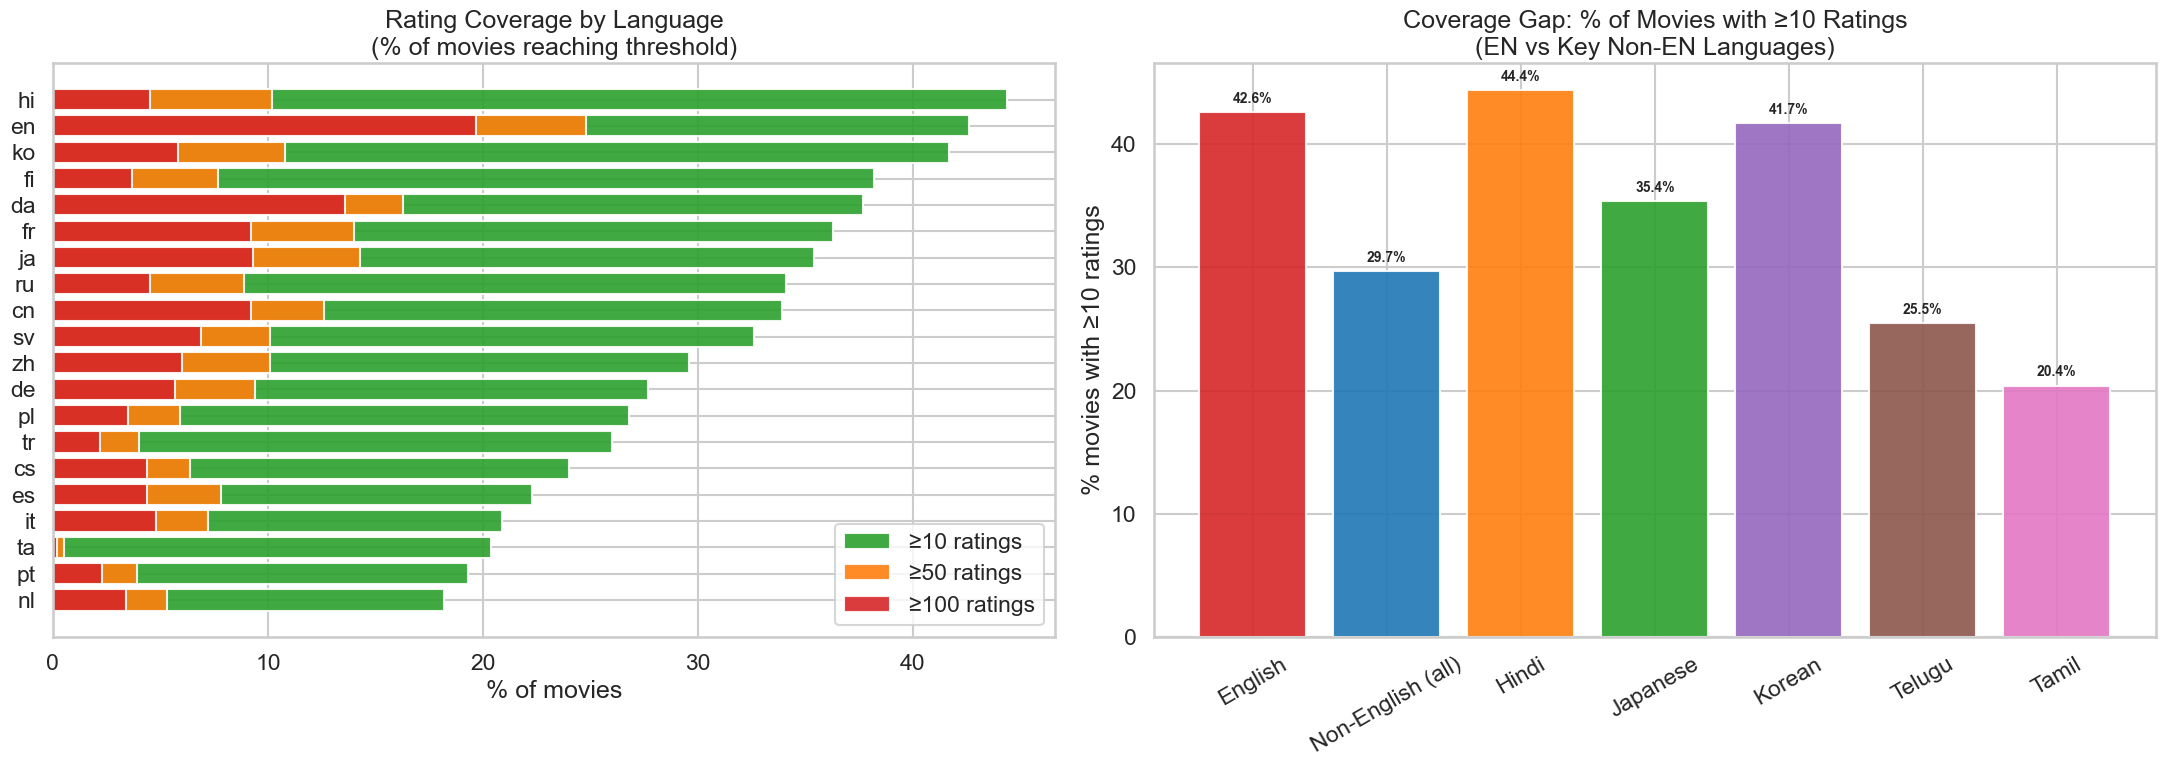


═══ COVERAGE GAP SUMMARY ═══
EN movies with ≥10 ratings: 42.6%
Non-EN movies with ≥10 ratings: 29.7%
Gap: 12.9 percentage points

→ Content-based recommendation is essential for non-EN films due to rating sparsity


In [20]:
# Coverage Gap: % of Non-EN Films with ≥10 Ratings

# Per-language coverage gap analysis
all_lang_coverage = (
    ml_tmdb[ml_tmdb['original_language'] != 'unknown']
    .groupby('original_language')
    .agg(
        total_movies=('movieId', 'nunique'),
        movies_ge10=('ratings_count', lambda s: int((s >= 10).sum())),
        movies_ge50=('ratings_count', lambda s: int((s >= 50).sum())),
        movies_ge100=('ratings_count', lambda s: int((s >= 100).sum())),
    )
)
all_lang_coverage['pct_ge10'] = (all_lang_coverage['movies_ge10'] / all_lang_coverage['total_movies'] * 100).round(1)
all_lang_coverage['pct_ge50'] = (all_lang_coverage['movies_ge50'] / all_lang_coverage['total_movies'] * 100).round(1)
all_lang_coverage['pct_ge100'] = (all_lang_coverage['movies_ge100'] / all_lang_coverage['total_movies'] * 100).round(1)

# Focus on languages with ≥50 movies
significant_langs = all_lang_coverage[all_lang_coverage['total_movies'] >= 50].sort_values('total_movies', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# Stacked bar: coverage thresholds
top20_coverage = significant_langs.head(20).sort_values('pct_ge10', ascending=True)
axes[0].barh(top20_coverage.index, top20_coverage['pct_ge10'], color='#2ca02c', alpha=0.9, label='≥10 ratings')
axes[0].barh(top20_coverage.index, top20_coverage['pct_ge50'], color='#ff7f0e', alpha=0.9, label='≥50 ratings')
axes[0].barh(top20_coverage.index, top20_coverage['pct_ge100'], color='#d62728', alpha=0.9, label='≥100 ratings')
axes[0].set_title('Rating Coverage by Language\n(% of movies reaching threshold)')
axes[0].set_xlabel('% of movies')
axes[0].legend(loc='lower right')

# Gap visualization: EN vs non-EN
en_ge10_pct = all_lang_coverage.loc['en', 'pct_ge10'] if 'en' in all_lang_coverage.index else 0
non_en_coverage = all_lang_coverage.drop('en', errors='ignore')
non_en_ge10_weighted = (non_en_coverage['movies_ge10'].sum() / non_en_coverage['total_movies'].sum() * 100)

gap_data = pd.DataFrame({
    'Category': ['English', 'Non-English (all)', 'Hindi', 'Japanese', 'Korean', 'Telugu', 'Tamil'],
    '≥10 ratings': [
        en_ge10_pct,
        non_en_ge10_weighted,
        all_lang_coverage.loc['hi', 'pct_ge10'] if 'hi' in all_lang_coverage.index else 0,
        all_lang_coverage.loc['ja', 'pct_ge10'] if 'ja' in all_lang_coverage.index else 0,
        all_lang_coverage.loc['ko', 'pct_ge10'] if 'ko' in all_lang_coverage.index else 0,
        all_lang_coverage.loc['te', 'pct_ge10'] if 'te' in all_lang_coverage.index else 0,
        all_lang_coverage.loc['ta', 'pct_ge10'] if 'ta' in all_lang_coverage.index else 0,
    ]
})

bars = axes[1].bar(gap_data['Category'], gap_data['≥10 ratings'],
                    color=['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#8c564b', '#e377c2'],
                    alpha=0.9, edgecolor='white')
for bar, val in zip(bars, gap_data['≥10 ratings']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.1f}%',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
axes[1].set_title('Coverage Gap: % of Movies with ≥10 Ratings\n(EN vs Key Non-EN Languages)')
axes[1].set_ylabel('% movies with ≥10 ratings')
axes[1].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

print(f'\n═══ COVERAGE GAP SUMMARY ═══')
print(f'EN movies with ≥10 ratings: {en_ge10_pct:.1f}%')
print(f'Non-EN movies with ≥10 ratings: {non_en_ge10_weighted:.1f}%')
print(f'Gap: {en_ge10_pct - non_en_ge10_weighted:.1f} percentage points')
print(f'\n→ Content-based recommendation is essential for non-EN films due to rating sparsity')

value
movieDoc_non_empty_pct  100.00
movieDoc_mean_len       373.00
movieDoc_median_len     318.00
movieDoc_p95_len        838.00
overview_non_empty_pct   77.38
overview_mean_len       265.60
overview_median_len     208.00
overview_p95_len        704.00
genres_non_empty_pct     56.41
genres_mean_len          11.90
genres_median_len        11.00
genres_p95_len           26.00
keywords_non_empty_pct   24.99
keywords_mean_len        37.80
keywords_median_len      24.00
keywords_p95_len        117.00

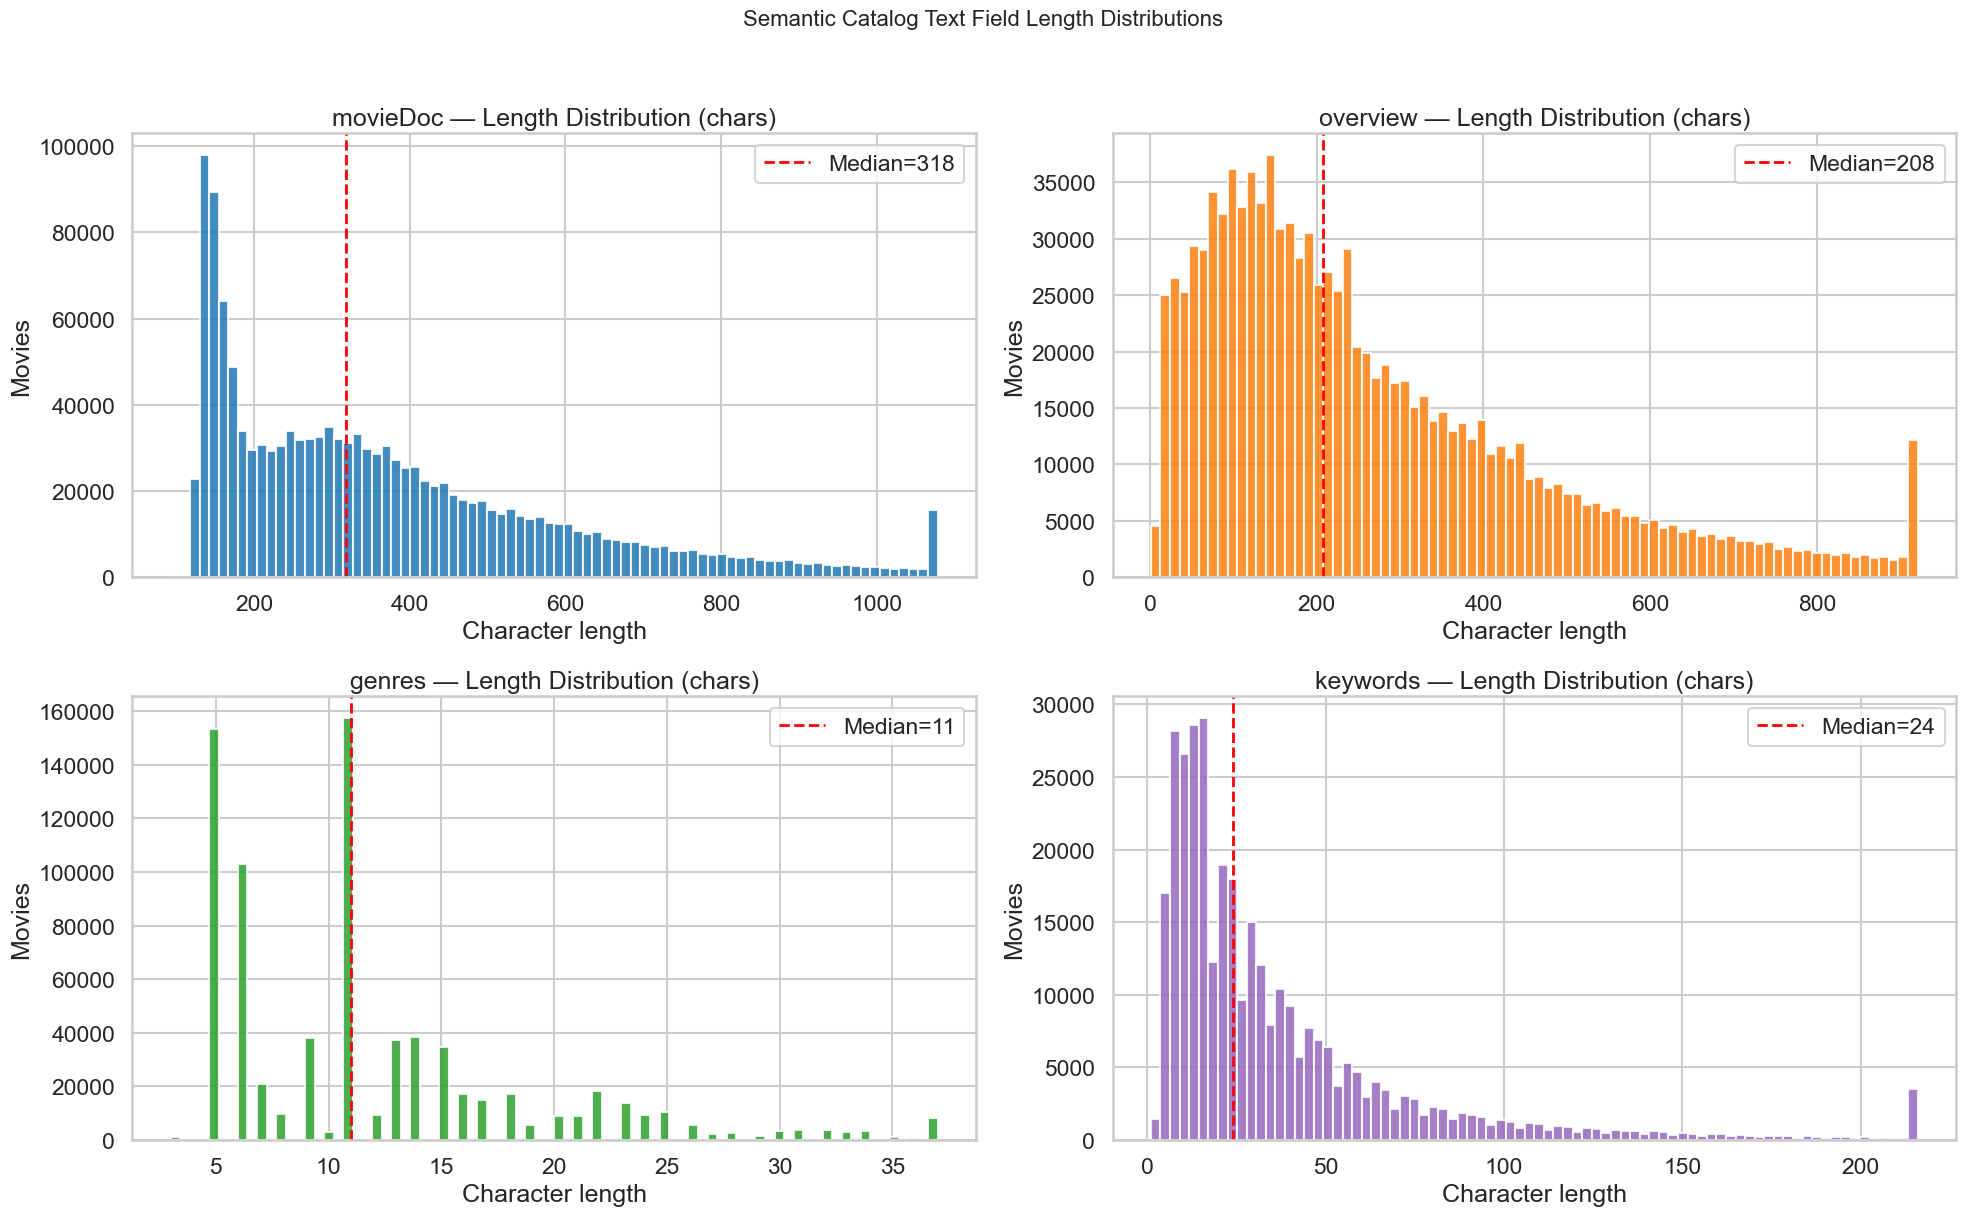


MovieDoc completeness by top languages:


count  movieDoc_pct  overview_pct
original_language                                      
en                 745199.0         100.0          93.2
fr                  79689.0         100.0          48.9
es                  69667.0         100.0          54.9
de                  62534.0         100.0          40.6
ja                  61485.0         100.0          75.1
zh                  44688.0         100.0          32.9
pt                  42441.0         100.0          38.5
it                  27741.0         100.0          54.0
ru                  27387.0         100.0          65.8
ko                  15257.0         100.0          72.6
cs                  12542.0         100.0          40.7
nl                  10604.0         100.0          51.7
ar                  10200.0         100.0          73.2
sv                   9737.0         100.0          73.8
tr                   9352.0         100.0          41.1

In [21]:
# MovieDoc Completeness & Length Distribution

semantic_cat = pd.read_csv(
    TMDB_SEMANTIC_PATH,
    usecols=['id', 'title', 'original_language', 'movieDoc', 'overview', 'genres', 'keywords', 'year'],
    low_memory=False,
)

semantic_cat['id'] = pd.to_numeric(semantic_cat['id'], errors='coerce').astype('Int64')
semantic_cat['original_language'] = semantic_cat['original_language'].fillna('unknown').astype(str).str.lower()

# Completeness metrics
def text_stats(series, col_name):
    s = series.fillna('').astype(str).str.strip()
    non_empty = (s != '')
    lengths = s[non_empty].str.len()
    return {
        f'{col_name}_non_empty_pct': round(non_empty.mean() * 100, 2),
        f'{col_name}_mean_len': round(lengths.mean(), 1) if len(lengths) > 0 else 0,
        f'{col_name}_median_len': round(lengths.median(), 1) if len(lengths) > 0 else 0,
        f'{col_name}_p95_len': round(lengths.quantile(0.95), 1) if len(lengths) > 0 else 0,
    }

completeness = {}
for col in ['movieDoc', 'overview', 'genres', 'keywords']:
    completeness.update(text_stats(semantic_cat[col], col))

completeness_df = pd.Series(completeness, name='value').to_frame()
display(completeness_df)

# Length distributions
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
for ax, col, color in zip(axes.flatten(), ['movieDoc', 'overview', 'genres', 'keywords'],
                           ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']):
    lengths = semantic_cat[col].fillna('').astype(str).str.strip().str.len()
    lengths_nonzero = lengths[lengths > 0]
    ax.hist(lengths_nonzero.clip(upper=lengths_nonzero.quantile(0.99)), bins=80, color=color, alpha=0.85, edgecolor='white')
    ax.axvline(lengths_nonzero.median(), color='red', ls='--', lw=2, label=f'Median={lengths_nonzero.median():.0f}')
    ax.set_title(f'{col} — Length Distribution (chars)')
    ax.set_xlabel('Character length')
    ax.set_ylabel('Movies')
    ax.legend()

plt.suptitle('Semantic Catalog Text Field Length Distributions', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Completeness by language
lang_completeness = (
    semantic_cat.groupby('original_language')
    .apply(lambda g: pd.Series({
        'count': len(g),
        'movieDoc_pct': round((g['movieDoc'].fillna('').astype(str).str.strip() != '').mean() * 100, 1),
        'overview_pct': round((g['overview'].fillna('').astype(str).str.strip() != '').mean() * 100, 1),
    }))
    .sort_values('count', ascending=False)
)
print('\nMovieDoc completeness by top languages:')
display(lang_completeness.head(15))

---
## Genre & Tag Analysis

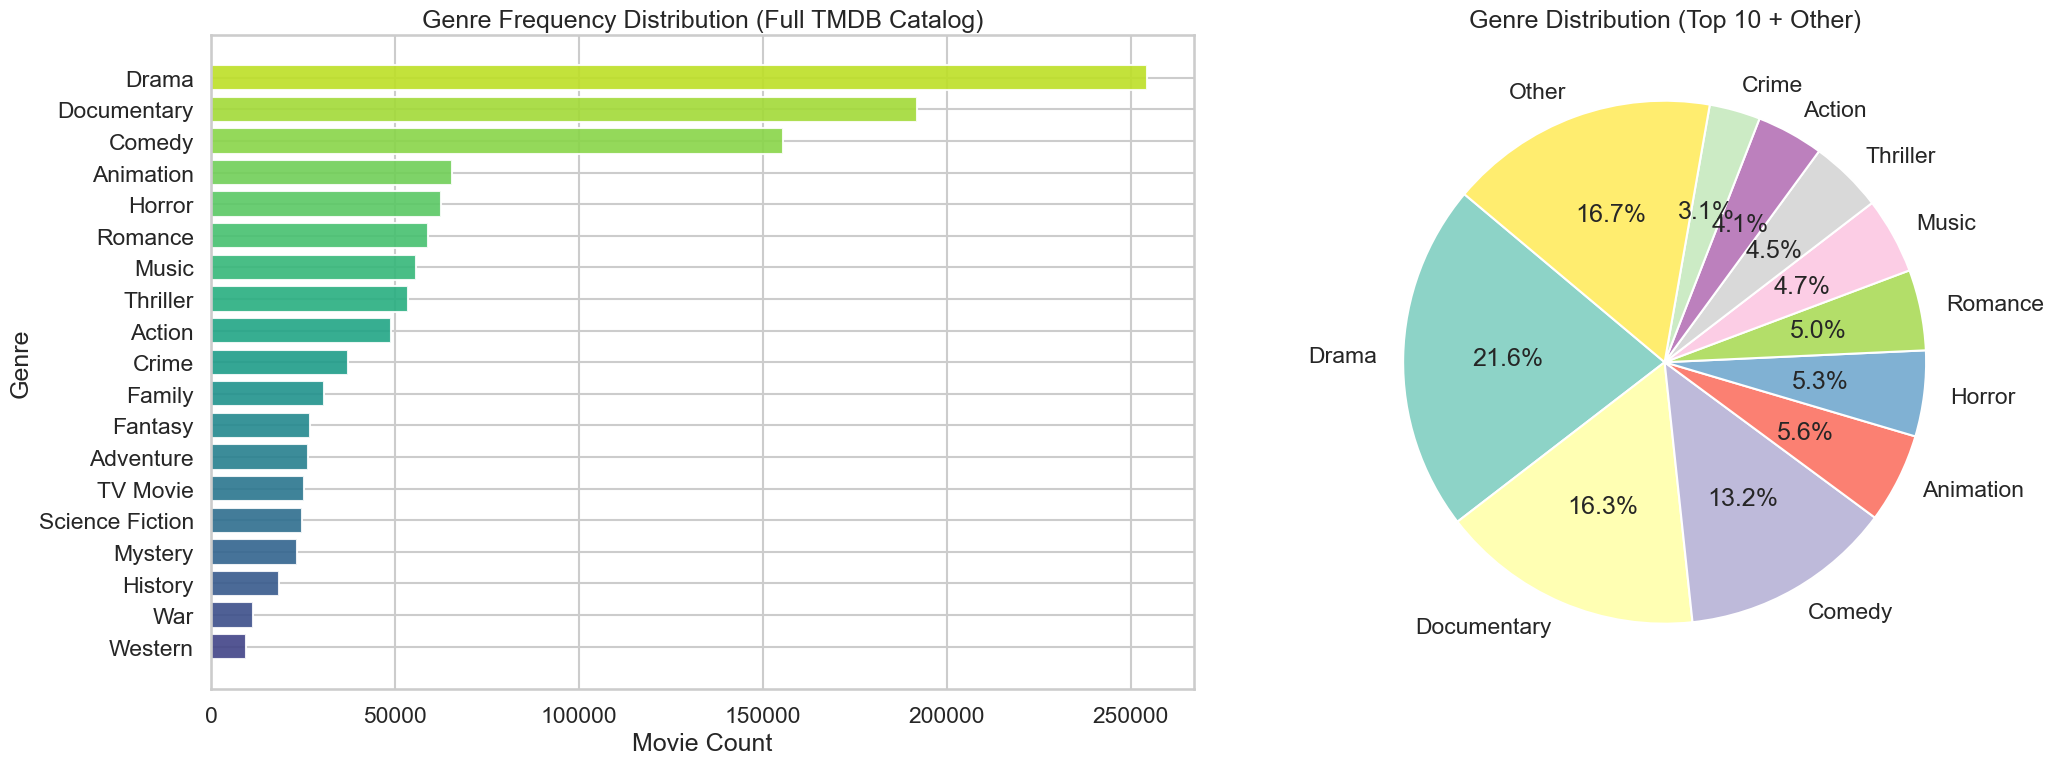

Total unique genres: 19
Total genre assignments: 1,180,250 (across 775,466 movies)
Avg genres per movie: 1.52


In [22]:
# Genre Frequency Distribution Across Full TMDB Catalog

# Explode genres
genre_series = tmdb['genres'].fillna('').astype(str).str.strip()
genre_series = genre_series[genre_series != '']

all_genres = genre_series.str.split(',').explode().str.strip()
all_genres = all_genres[all_genres != '']
genre_freq = all_genres.value_counts()

fig, axes = plt.subplots(1, 2, figsize=(22, 8))

# Bar chart
genre_freq_sorted = genre_freq.sort_values(ascending=True)
axes[0].barh(genre_freq_sorted.index, genre_freq_sorted.values, color=plt.cm.viridis(np.linspace(0.2, 0.9, len(genre_freq_sorted))), alpha=0.9)
axes[0].set_title('Genre Frequency Distribution (Full TMDB Catalog)')
axes[0].set_xlabel('Movie Count')
axes[0].set_ylabel('Genre')

# Pie for top genres
top_genres = genre_freq.head(10)
other_genres = genre_freq.iloc[10:].sum()
pie_genre = pd.concat([top_genres, pd.Series({'Other': other_genres})])
axes[1].pie(pie_genre.values, labels=pie_genre.index, autopct='%1.1f%%',
            startangle=140, colors=plt.cm.Set3(np.linspace(0, 1, len(pie_genre))),
            wedgeprops={'edgecolor': 'white'})
axes[1].set_title('Genre Distribution (Top 10 + Other)')

plt.tight_layout()
plt.show()

print(f'Total unique genres: {genre_freq.shape[0]}')
print(f'Total genre assignments: {len(all_genres):,} (across {len(genre_series):,} movies)')
print(f'Avg genres per movie: {all_genres.groupby(level=0).count().mean():.2f}')

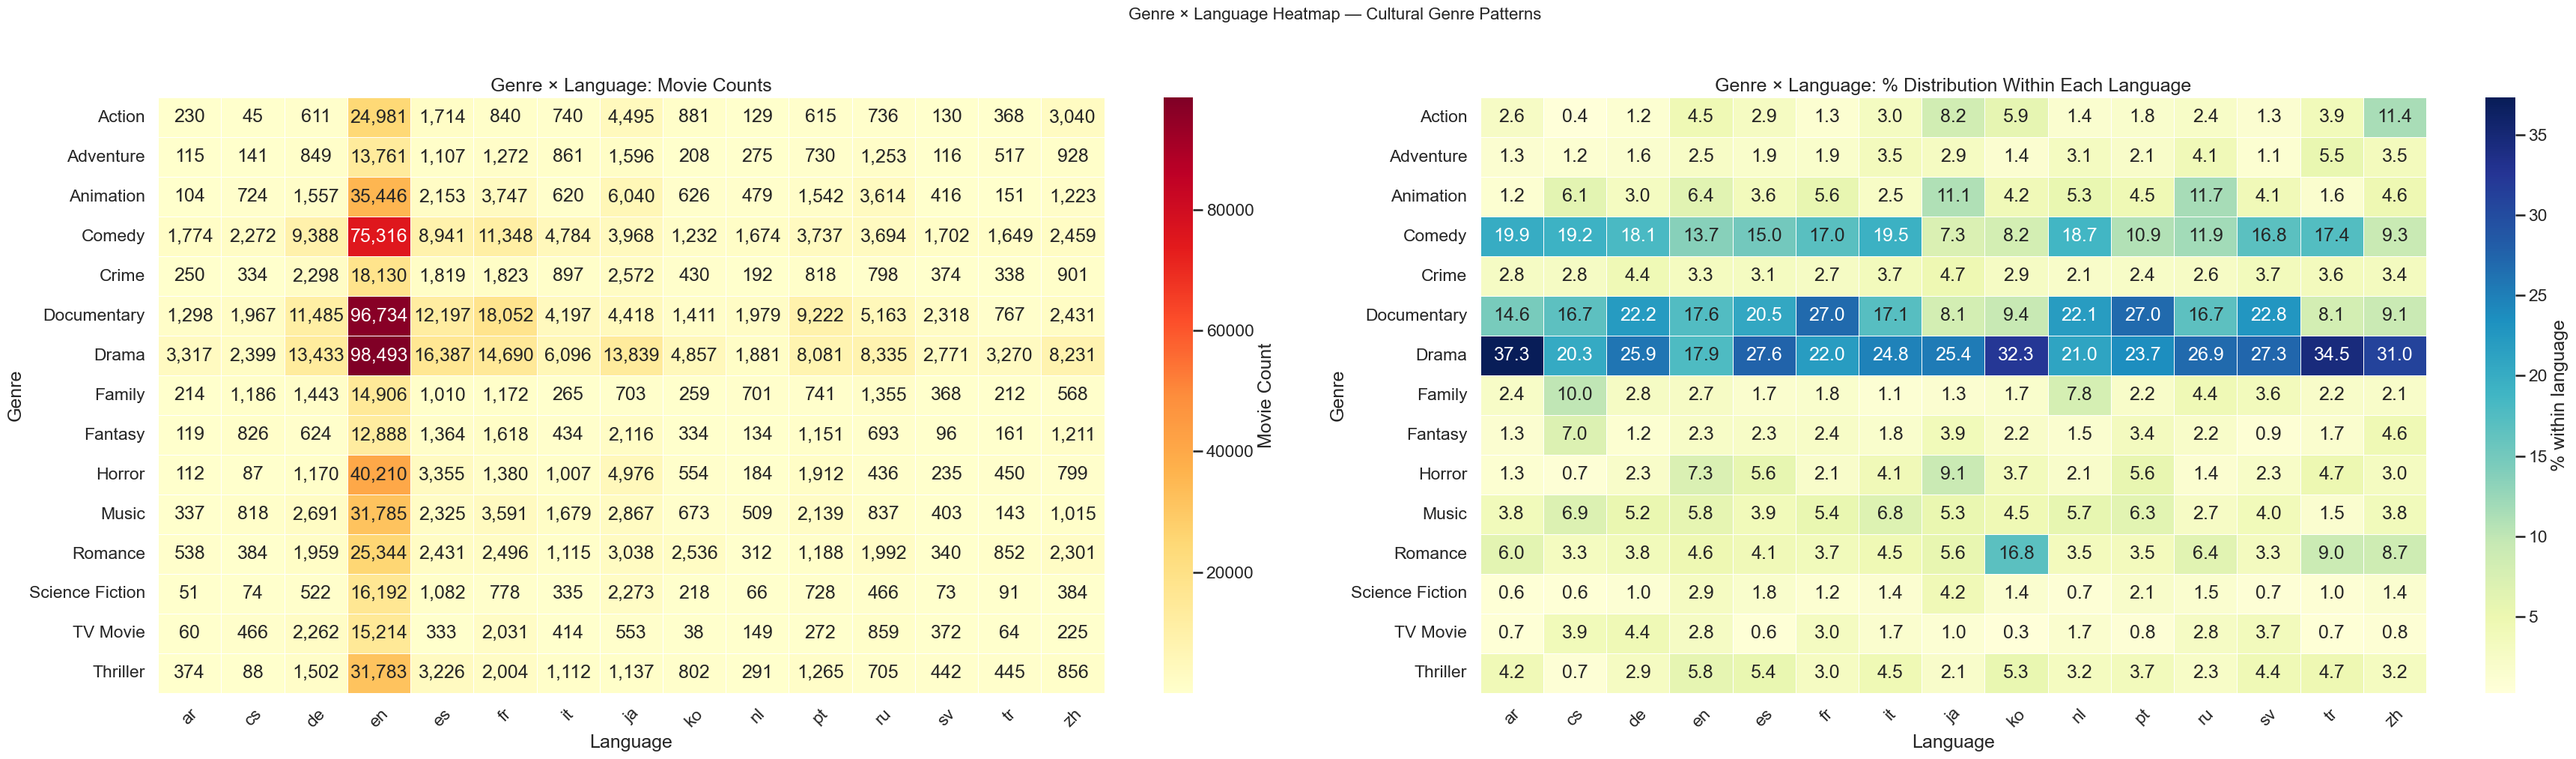

In [23]:
# Genre × Language Heatmap 
top_langs_for_heatmap = tmdb['original_language'].value_counts().head(15).index.tolist()
top_genres_for_heatmap = genre_freq.head(15).index.tolist()

# Explode genres per movie and cross with language
tmdb_genre_exploded = tmdb[['id', 'original_language', 'genres']].copy()
tmdb_genre_exploded['genre_list'] = tmdb_genre_exploded['genres'].fillna('').str.split(',')
tmdb_genre_exploded = tmdb_genre_exploded.explode('genre_list')
tmdb_genre_exploded['genre_list'] = tmdb_genre_exploded['genre_list'].str.strip()
tmdb_genre_exploded = tmdb_genre_exploded[
    (tmdb_genre_exploded['original_language'].isin(top_langs_for_heatmap)) &
    (tmdb_genre_exploded['genre_list'].isin(top_genres_for_heatmap))
]

genre_lang_matrix = tmdb_genre_exploded.pivot_table(
    index='genre_list', columns='original_language', values='id', aggfunc='count', fill_value=0
)

genre_lang_matrix = genre_lang_matrix.astype(int)

# Normalize per language (column-wise) to show genre proportion within each language
genre_lang_pct = genre_lang_matrix.div(genre_lang_matrix.sum(axis=0), axis=1) * 100

fig, axes = plt.subplots(1, 2, figsize=(36, 10))

# Raw count heatmap
sns.heatmap(genre_lang_matrix, annot=True, fmt=',d', cmap='YlOrRd', ax=axes[0],
            linewidths=0.5, cbar_kws={'label': 'Movie Count'})
axes[0].set_title('Genre × Language: Movie Counts')
axes[0].set_xlabel('Language')
axes[0].set_ylabel('Genre')
axes[0].tick_params(axis='x', rotation=45)

# Normalized heatmap (% within language)
sns.heatmap(genre_lang_pct, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[1],
            linewidths=0.5, cbar_kws={'label': '% within language'})
axes[1].set_title('Genre × Language: % Distribution Within Each Language')
axes[1].set_xlabel('Language')
axes[1].set_ylabel('Genre')
axes[1].tick_params(axis='x', rotation=45)

plt.suptitle('Genre × Language Heatmap — Cultural Genre Patterns', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

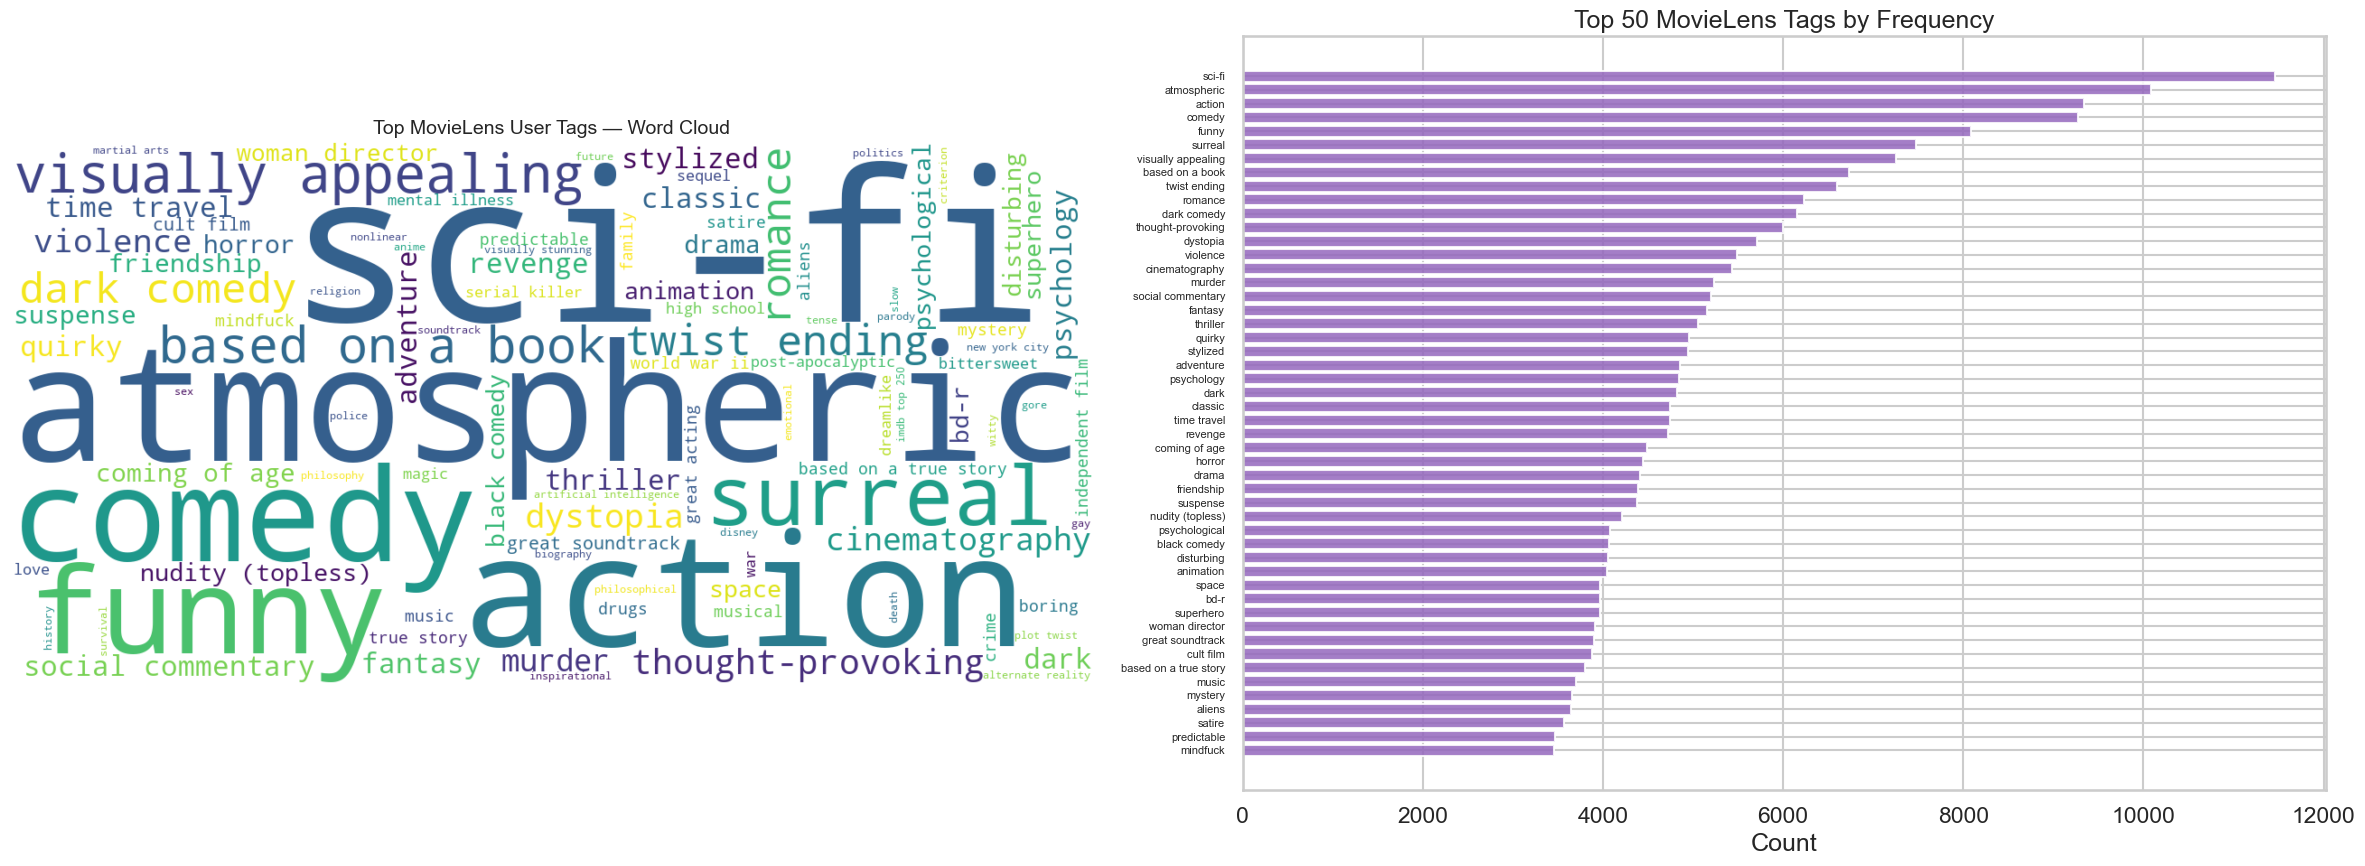

Top 200 MovieLens tags: 200
Unique TMDB keywords: 67,194
Overlap (tags also in TMDB keywords): 178 (89.0%)

Sample overlapping terms: ['1980s', 'acting', 'action', 'adventure', 'aliens', 'alternate reality', 'animation', 'anime', 'apocalypse', 'artificial intelligence', 'assassin', 'atmospheric', 'bad acting', 'based on a true story', 'based on novel or book', 'beautiful', 'biography', 'bittersweet', 'black and white', 'black comedy']
Sample tag-only terms: ['based on a book', 'bd-r', 'clever', 'clv', 'father-son relationship', 'great ending', 'great soundtrack', 'imdb top 250', 'johnny depp', 'leonardo dicaprio', 'mindfuck', 'nonlinear', 'nudity (full frontal)', 'nudity (topless)', 'oscar (best picture)']


In [24]:
# Top 50 MovieLens Tags — Word Cloud & Tag–Keyword Overlap
from wordcloud import WordCloud

# Word cloud from tag frequencies
tag_freq_dict = tag_counts.head(200).to_dict()

fig, axes = plt.subplots(1, 2, figsize=(24, 9))

wc = WordCloud(width=1200, height=600, background_color='white',
               colormap='viridis', max_words=100, prefer_horizontal=0.7)
wc.generate_from_frequencies(tag_freq_dict)
axes[0].imshow(wc, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Top MovieLens User Tags — Word Cloud', fontsize=14)

# Top 50 tags bar
top50 = tag_counts.head(50).sort_values(ascending=True)
axes[1].barh(top50.index, top50.values, color='#9467bd', alpha=0.85, edgecolor='white', height=0.8)
axes[1].set_title('Top 50 MovieLens Tags by Frequency')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('')
axes[1].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

# Tag × TMDB Keyword Overlap Check
tmdb_keywords_series = tmdb['keywords'].fillna('').astype(str).str.strip()
tmdb_keywords_series = tmdb_keywords_series[tmdb_keywords_series != '']
all_keywords = tmdb_keywords_series.str.lower().str.split(',').explode().str.strip()
all_keywords = all_keywords[all_keywords != '']
unique_keywords = set(all_keywords.unique())

top_ml_tags = set(tag_counts.head(200).index)
overlap = top_ml_tags & unique_keywords
only_tags = top_ml_tags - unique_keywords
only_keywords = unique_keywords - top_ml_tags


print(f'Top 200 MovieLens tags: {len(top_ml_tags)}')
print(f'Unique TMDB keywords: {len(unique_keywords):,}')
print(f'Overlap (tags also in TMDB keywords): {len(overlap)} ({len(overlap)/len(top_ml_tags)*100:.1f}%)')
print(f'\nSample overlapping terms: {sorted(list(overlap))[:20]}')
print(f'Sample tag-only terms: {sorted(list(only_tags))[:15]}')

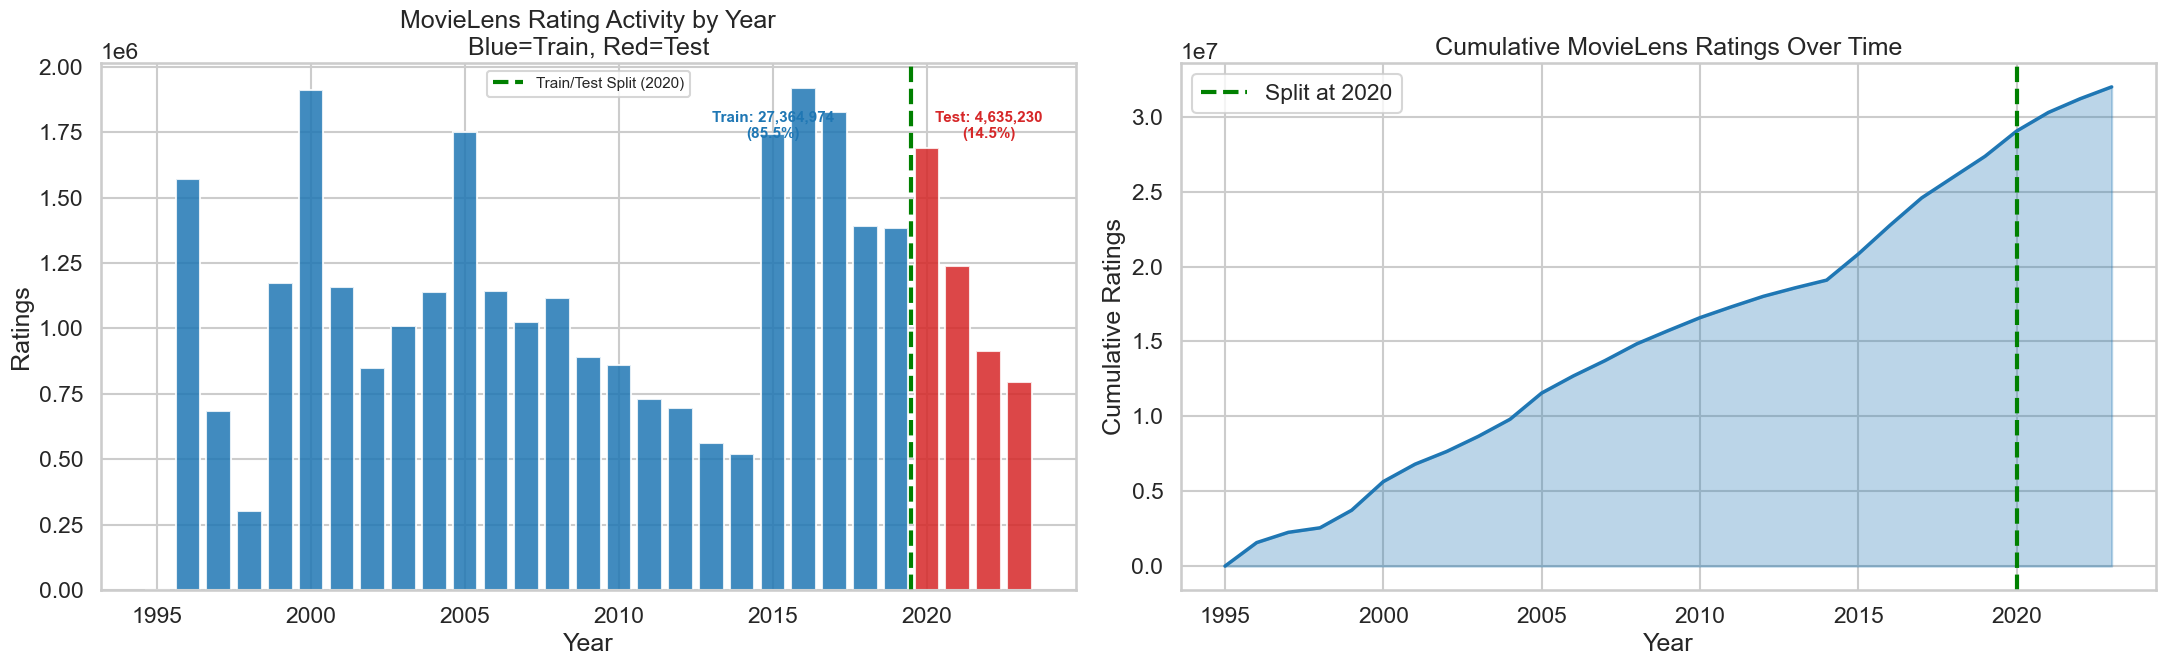

Train period (< 2020): 27,364,974 ratings (85.5%)
Test period (≥ 2020): 4,635,230 ratings (14.5%)


In [25]:
# Rating Activity by Year — Train/Test Split Visualization 

# Yearly ratings volume from monthly_counts
yearly_counts = monthly_counts.copy()
yearly_counts.index = yearly_counts.index.to_timestamp()
yearly_agg = yearly_counts.groupby(yearly_counts.index.year).sum()

split_year = 2020
train_ratings = yearly_agg[yearly_agg.index < split_year].sum()
test_ratings = yearly_agg[yearly_agg.index >= split_year].sum()
total_ratings = train_ratings + test_ratings

fig, axes = plt.subplots(1, 2, figsize=(22, 7))

# Bar chart with train/test coloring
colors = ['#1f77b4' if y < split_year else '#d62728' for y in yearly_agg.index]
axes[0].bar(yearly_agg.index, yearly_agg.values, color=colors, alpha=0.85, edgecolor='white')
axes[0].axvline(split_year - 0.5, color='green', ls='--', lw=3, label=f'Train/Test Split ({split_year})')
axes[0].set_title('MovieLens Rating Activity by Year\nBlue=Train, Red=Test')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Ratings')
axes[0].legend(fontsize=11)

# Add text annotations
axes[0].text(split_year - 5, yearly_agg.max() * 0.9,
             f'Train: {train_ratings:,.0f}\n({train_ratings/total_ratings*100:.1f}%)',
             fontsize=11, ha='center', color='#1f77b4', fontweight='bold')
axes[0].text(split_year + 2, yearly_agg.max() * 0.9,
             f'Test: {test_ratings:,.0f}\n({test_ratings/total_ratings*100:.1f}%)',
             fontsize=11, ha='center', color='#d62728', fontweight='bold')

# Cumulative plot
cumulative_yearly = yearly_agg.cumsum()
axes[1].fill_between(cumulative_yearly.index, cumulative_yearly.values, alpha=0.3, color='#1f77b4')
axes[1].plot(cumulative_yearly.index, cumulative_yearly.values, color='#1f77b4', linewidth=2.5)
axes[1].axvline(split_year, color='green', ls='--', lw=3, label=f'Split at {split_year}')
axes[1].set_title('Cumulative MovieLens Ratings Over Time')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Cumulative Ratings')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f'Train period (< {split_year}): {train_ratings:,.0f} ratings ({train_ratings/total_ratings*100:.1f}%)')
print(f'Test period (≥ {split_year}): {test_ratings:,.0f} ratings ({test_ratings/total_ratings*100:.1f}%)')

/var/folders/lq/r8qjzl2x10b2vksfq2gq9m080000gn/T/ipykernel_21232/4092271433.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=violin_data, y='original_language', x='vote_average',


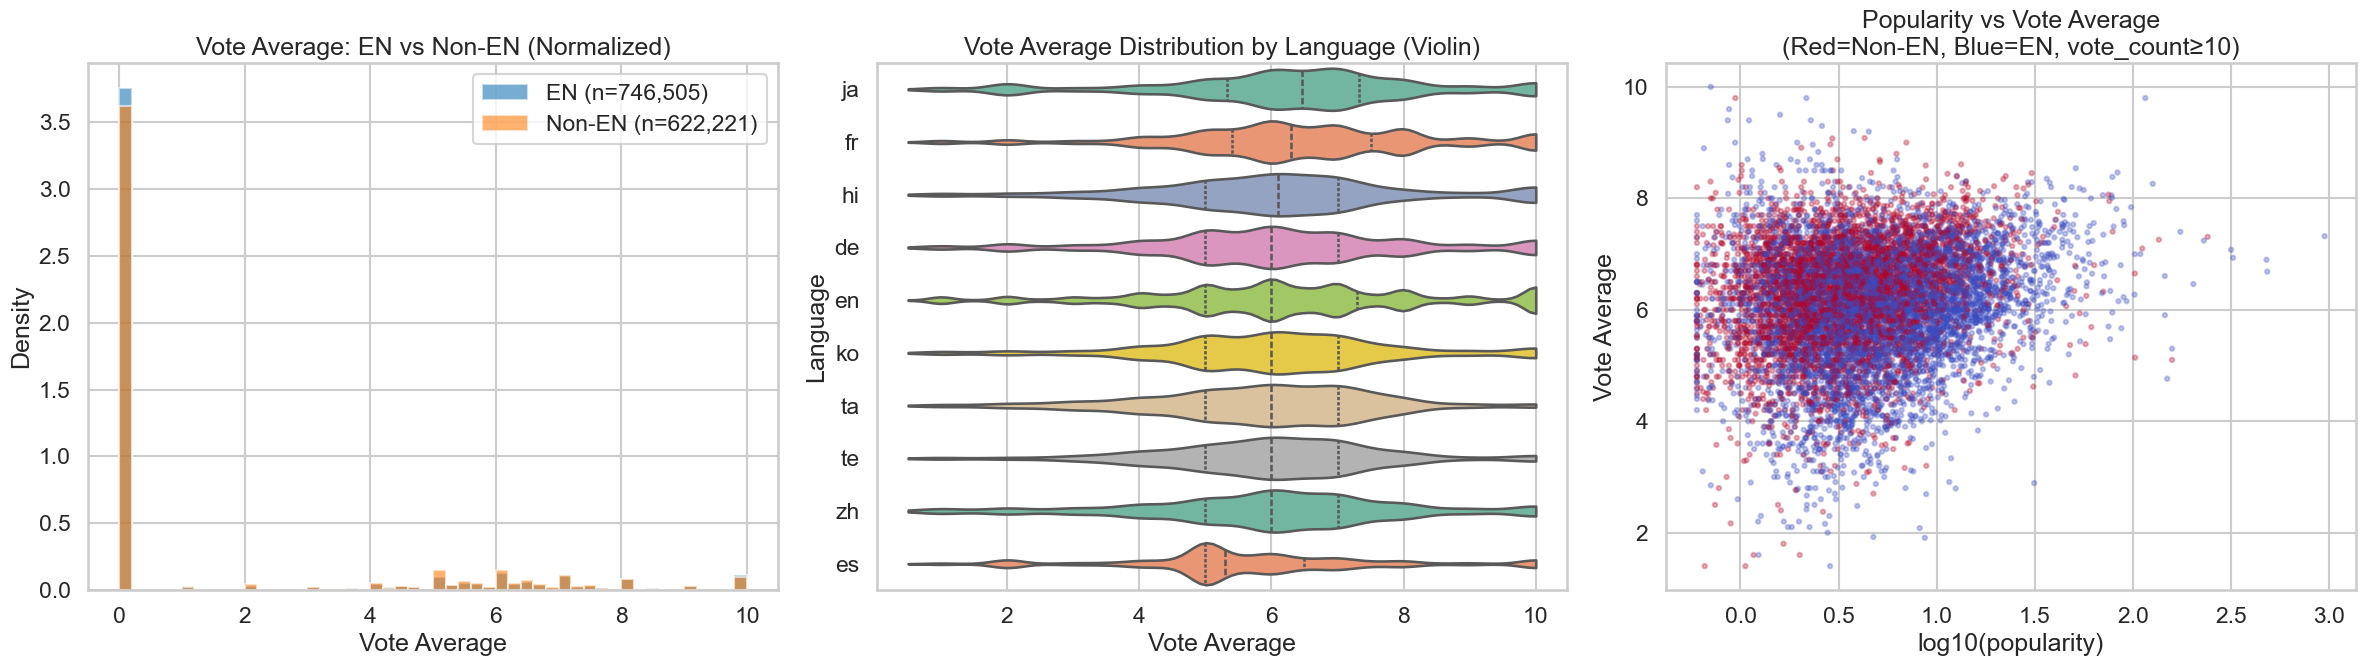


EN mean vote_avg: 1.534 ± 2.858
Non-EN mean vote_avg: 1.689 ± 2.916
Welch t-test: t=-31.25, p=3.10e-214 → Significant difference


In [26]:
#  Vote Average Distribution: EN vs Non-EN 

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# 1. Overlapping histogram: EN vs Non-EN vote averages
en_votes = tmdb[tmdb['original_language'] == 'en']['vote_average'].dropna()
non_en_votes = tmdb[tmdb['original_language'] != 'en']['vote_average'].dropna()

axes[0].hist(en_votes, bins=50, alpha=0.6, color='#1f77b4', label=f'EN (n={len(en_votes):,})', density=True)
axes[0].hist(non_en_votes, bins=50, alpha=0.6, color='#ff7f0e', label=f'Non-EN (n={len(non_en_votes):,})', density=True)
axes[0].set_title('Vote Average: EN vs Non-EN (Normalized)')
axes[0].set_xlabel('Vote Average')
axes[0].set_ylabel('Density')
axes[0].legend()

# 2. Violin plot of vote_average by focus languages
violin_data = tmdb[tmdb['original_language'].isin(focus_langs)].copy()
violin_data = violin_data[violin_data['vote_average'] > 0]  # exclude zeros

# Sort languages by median vote_average
lang_order = (violin_data.groupby('original_language')['vote_average'].median()
              .sort_values(ascending=False).index.tolist())

sns.violinplot(data=violin_data, y='original_language', x='vote_average',
               order=lang_order, palette='Set2', ax=axes[1], inner='quartile', cut=0)
axes[1].set_title('Vote Average Distribution by Language (Violin)')
axes[1].set_xlabel('Vote Average')
axes[1].set_ylabel('Language')

# 3. Popularity vs Vote Average scatter (sampled)
sample_df = tmdb[(tmdb['vote_count'] >= 10) & (tmdb['popularity'] > 0)].sample(
    min(10000, len(tmdb)), random_state=42
)
scatter = axes[2].scatter(
    np.log10(sample_df['popularity']),
    sample_df['vote_average'],
    c=sample_df['original_language'].apply(lambda x: 0 if x == 'en' else 1),
    cmap='coolwarm', alpha=0.3, s=10
)
axes[2].set_title('Popularity vs Vote Average\n(Red=Non-EN, Blue=EN, vote_count≥10)')
axes[2].set_xlabel('log10(popularity)')
axes[2].set_ylabel('Vote Average')

plt.tight_layout()
plt.show()

# Statistical comparison
from scipy import stats
t_stat, p_val = stats.ttest_ind(en_votes, non_en_votes, equal_var=False)
print(f'\nEN mean vote_avg: {en_votes.mean():.3f} ± {en_votes.std():.3f}')
print(f'Non-EN mean vote_avg: {non_en_votes.mean():.3f} ± {non_en_votes.std():.3f}')
print(f'Welch t-test: t={t_stat:.2f}, p={p_val:.2e} → {"Significant" if p_val < 0.05 else "Not significant"} difference')

═══ IMDB FILES FOUND ═══
  name.basics.tsv.gz (284.7 MB): ['nconst', 'primaryName', 'birthYear', 'deathYear', 'primaryProfession', 'knownForTitles']
  title.akas.tsv.gz (456.3 MB): ['titleId', 'ordering', 'title', 'region', 'language', 'types', 'attributes', 'isOriginalTitle']
  title.basics.tsv.gz (207.5 MB): ['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes', 'genres']
  title.crew.tsv.gz (76.5 MB): ['tconst', 'directors', 'writers']
  title.episode.tsv.gz (50.0 MB): ['tconst', 'parentTconst', 'seasonNumber', 'episodeNumber']
  title.principals.tsv.gz (718.0 MB): ['tconst', 'ordering', 'nconst', 'category', 'job', 'characters']
  title.ratings.tsv.gz (7.9 MB): ['tconst', 'averageRating', 'numVotes']

═══ LOADING BASICS FROM: /Users/roop/Downloads/IMDB0226/title.basics.tsv.gz ═══
Raw basics shape: (12285042, 9)
Columns: ['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes',

missing_pct
endYear              100.00
runtimeMinutes        35.94
startYear             12.86
genres                10.23
tconst                 0.00
titleType              0.00
primaryTitle           0.00
originalTitle          0.00
isAdult                0.00


IMDB movies with genres: 800,339 (89.8%)
IMDB movies missing genres: 91,195 (10.2%)
Unique IMDB genres: 28


count
genres             
Drama        311027
Documentary  193787
Comedy       150626
Action        63979
Romance       59006
Thriller      57072
Crime         49264
Horror        47608
Adventure     34315
Family        26230
Biography     24895
Music         24435
Mystery       23267
History       20861
Fantasy       20474


═══ IMDB RATINGS ═══
Shape: (1634568, 3)
Columns: ['tconst', 'averageRating', 'numVotes']
Movies with ratings: 395,171 (44.3%)
Movies without ratings: 496,363


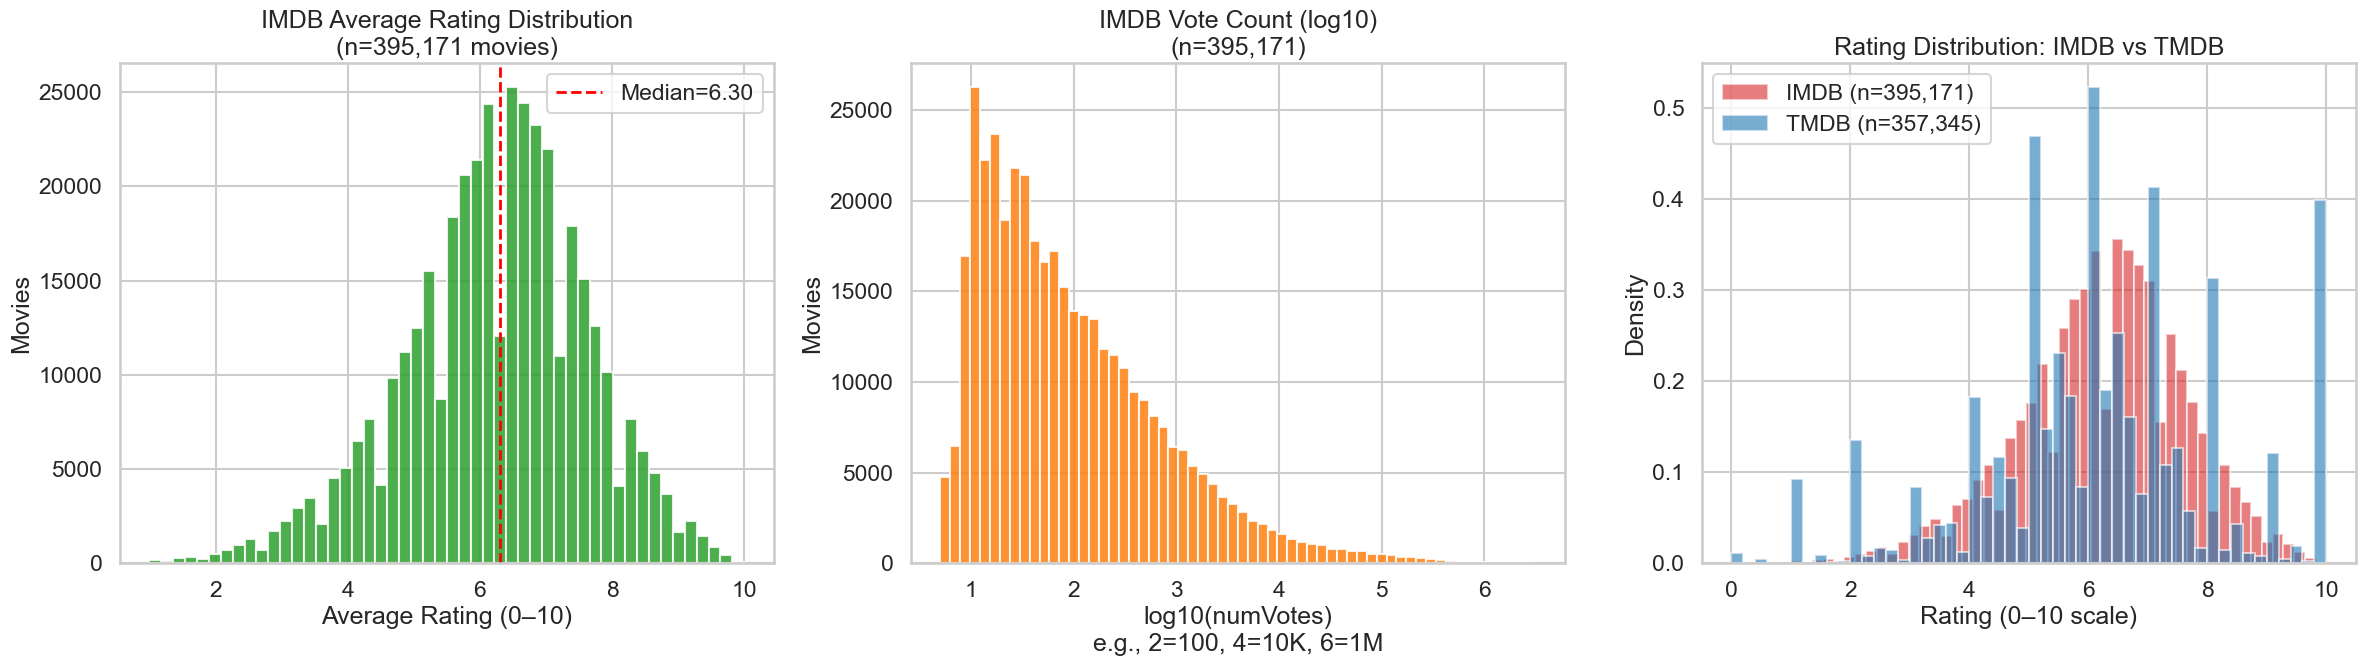


═══ IMDB ↔ TMDB OVERLAP ═══
TMDB columns available: ['id', 'title', 'vote_average', 'vote_count', 'status', 'release_date', 'revenue', 'runtime', 'adult', 'backdrop_path', 'budget', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'tagline', 'genres', 'production_companies', 'production_countries', 'spoken_languages', 'keywords']
TMDB movies with imdb_id: 653,274
IMDB movies (tconst): 891,534
Overlap (in both): 401,536 (45.0% of IMDB)
Only in TMDB: 251,738
Only in IMDB: 489,998


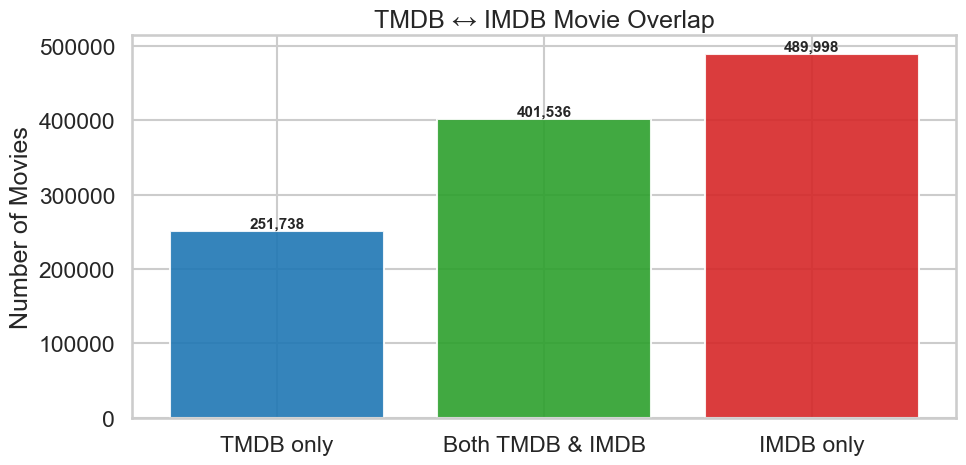


═══ IMDB SUMMARY ═══


value
total_imdb_movies  891534
with_genres        800339
with_ratings       395171
with_numVotes      395171

In [27]:
# IMDB Dataset EDA — Completeness & Overlap with TMDB

from pathlib import Path
import glob

IMDB_DIR = Path('/Users/roop/Downloads/IMDB0226')

print('═══ IMDB FILES FOUND ═══')
imdb_files = {}
for f in sorted(IMDB_DIR.glob('*.tsv.gz')) + sorted(IMDB_DIR.glob('*.tsv')) + sorted(IMDB_DIR.glob('*.csv')):
    try:
        header = pd.read_csv(f, sep='\t', nrows=0)
        imdb_files[f.name] = f
        size_mb = f.stat().st_size / (1024**2)
        print(f'  {f.name} ({size_mb:.1f} MB): {list(header.columns)}')
    except Exception as e:
        print(f'  {f.name}: ERROR — {e}')

# 2. Load title.basics (filter to movies only)
basics_path = IMDB_DIR / 'title.basics.tsv.gz' if (IMDB_DIR / 'title.basics.tsv.gz').exists() else IMDB_DIR / 'title.basics.tsv'
if not basics_path.exists():
    candidates = list(IMDB_DIR.glob('*basics*'))
    basics_path = candidates[0] if candidates else None

print(f'\n═══ LOADING BASICS FROM: {basics_path} ═══')
basics = pd.read_csv(basics_path, sep='\t', low_memory=False, na_values='\\N')
print(f'Raw basics shape: {basics.shape}')
print(f'Columns: {list(basics.columns)}')
print(f'titleType values:\n{basics["titleType"].value_counts().head(10)}')

# Filter to movies only
imdb_movies = basics[basics['titleType'].isin(['movie', 'tvMovie'])].copy()
print(f'\nIMDB movies (movie + tvMovie): {len(imdb_movies):,}')

# 3. Missing genres & keywords analysis
def missing_pct(series):
    s = series.fillna('').astype(str).str.strip()
    empty = (s == '') | (s == '\\N') | (s.str.lower() == 'nan')
    return round(empty.mean() * 100, 2)

imdb_completeness = {}
for col in imdb_movies.columns:
    imdb_completeness[col] = missing_pct(imdb_movies[col])

imdb_completeness_df = pd.Series(imdb_completeness, name='missing_pct').sort_values(ascending=False).to_frame()
print('\n═══ IMDB MOVIE MISSING % ═══')
display(imdb_completeness_df)

# Genre analysis
if 'genres' in imdb_movies.columns:
    genre_filled = imdb_movies['genres'].fillna('').astype(str).str.strip()
    genre_valid = genre_filled[(genre_filled != '') & (genre_filled != '\\N')]
    print(f'\nIMDB movies with genres: {len(genre_valid):,} ({len(genre_valid)/len(imdb_movies)*100:.1f}%)')
    print(f'IMDB movies missing genres: {len(imdb_movies) - len(genre_valid):,} ({(len(imdb_movies)-len(genre_valid))/len(imdb_movies)*100:.1f}%)')
    
    imdb_genres = genre_valid.str.split(',').explode().str.strip()
    imdb_genre_freq = imdb_genres.value_counts()
    print(f'Unique IMDB genres: {imdb_genre_freq.shape[0]}')
    display(imdb_genre_freq.head(15).to_frame('count'))

# 4. Load ratings if available
ratings_path = IMDB_DIR / 'title.ratings.tsv.gz' if (IMDB_DIR / 'title.ratings.tsv.gz').exists() else IMDB_DIR / 'title.ratings.tsv'
if not ratings_path.exists():
    candidates = list(IMDB_DIR.glob('*ratings*'))
    ratings_path = candidates[0] if candidates else None

if ratings_path and ratings_path.exists():
    imdb_ratings = pd.read_csv(ratings_path, sep='\t', low_memory=False, na_values='\\N')
    print(f'\n═══ IMDB RATINGS ═══')
    print(f'Shape: {imdb_ratings.shape}')
    print(f'Columns: {list(imdb_ratings.columns)}')
    
    # Merge with movies
    imdb_movies = imdb_movies.merge(imdb_ratings, on='tconst', how='left')
    
    rated_movies = imdb_movies[imdb_movies['averageRating'].notna()]
    print(f'Movies with ratings: {len(rated_movies):,} ({len(rated_movies)/len(imdb_movies)*100:.1f}%)')
    print(f'Movies without ratings: {len(imdb_movies)-len(rated_movies):,}')
    
    # Distribution plots
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    
    # Vote average distribution
    axes[0].hist(rated_movies['averageRating'].dropna(), bins=50, color='#2ca02c', alpha=0.85, edgecolor='white')
    axes[0].axvline(rated_movies['averageRating'].median(), color='red', ls='--', lw=2, 
                    label=f'Median={rated_movies["averageRating"].median():.2f}')
    axes[0].set_title(f'IMDB Average Rating Distribution\n(n={len(rated_movies):,} movies)')
    axes[0].set_xlabel('Average Rating (0–10)')
    axes[0].set_ylabel('Movies')
    axes[0].legend()
    
    # Vote count (numVotes) distribution
    if 'numVotes' in imdb_movies.columns:
        votes_nonzero = rated_movies.loc[rated_movies['numVotes'] > 0, 'numVotes']
        axes[1].hist(np.log10(votes_nonzero), bins=60, color='#ff7f0e', alpha=0.85, edgecolor='white')
        axes[1].set_title(f'IMDB Vote Count (log10)\n(n={len(votes_nonzero):,})')
        axes[1].set_xlabel('log10(numVotes)\ne.g., 2=100, 4=10K, 6=1M')
        axes[1].set_ylabel('Movies')
    
    # IMDB vs TMDB rating comparison (side by side)
    axes[2].hist(rated_movies['averageRating'].dropna(), bins=50, alpha=0.6, color='#d62728', 
                 label=f'IMDB (n={len(rated_movies):,})', density=True)
    axes[2].hist(tmdb_voted['vote_average'].dropna(), bins=50, alpha=0.6, color='#1f77b4',
                 label=f'TMDB (n={len(tmdb_voted):,})', density=True)
    axes[2].set_title('Rating Distribution: IMDB vs TMDB')
    axes[2].set_xlabel('Rating (0–10 scale)')
    axes[2].set_ylabel('Density')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

# 5. IMDB ↔ TMDB Overlap
print('\n═══ IMDB ↔ TMDB OVERLAP ═══')

# TMDB has imdb_id? Check if we loaded it
# Re-read TMDB with imdb_id if available
tmdb_full_cols = pd.read_csv(TMDB_PATH, nrows=0).columns.tolist()
print(f'TMDB columns available: {tmdb_full_cols}')

if 'imdb_id' in tmdb_full_cols:
    tmdb_imdb = pd.read_csv(TMDB_PATH, usecols=['id', 'imdb_id'], low_memory=False)
    tmdb_imdb['imdb_id'] = tmdb_imdb['imdb_id'].fillna('').astype(str).str.strip()
    tmdb_imdb = tmdb_imdb[tmdb_imdb['imdb_id'].str.startswith('tt')]
    
    tmdb_imdb_set = set(tmdb_imdb['imdb_id'].unique())
    imdb_tconst_set = set(imdb_movies['tconst'].unique())
    
    overlap_ids = tmdb_imdb_set & imdb_tconst_set
    only_tmdb = tmdb_imdb_set - imdb_tconst_set
    only_imdb = imdb_tconst_set - tmdb_imdb_set
    
    print(f'TMDB movies with imdb_id: {len(tmdb_imdb_set):,}')
    print(f'IMDB movies (tconst): {len(imdb_tconst_set):,}')
    print(f'Overlap (in both): {len(overlap_ids):,} ({len(overlap_ids)/len(imdb_tconst_set)*100:.1f}% of IMDB)')
    print(f'Only in TMDB: {len(only_tmdb):,}')
    print(f'Only in IMDB: {len(only_imdb):,}')
    
    # Venn-style bar
    fig, ax = plt.subplots(figsize=(10, 5))
    venn_data = pd.Series({
        'TMDB only': len(only_tmdb),
        'Both TMDB & IMDB': len(overlap_ids),
        'IMDB only': len(only_imdb),
    })
    bars = ax.bar(venn_data.index, venn_data.values, 
                  color=['#1f77b4', '#2ca02c', '#d62728'], alpha=0.9, edgecolor='white')
    for bar, val in zip(bars, venn_data.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, f'{val:,}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    ax.set_title('TMDB ↔ IMDB Movie Overlap')
    ax.set_ylabel('Number of Movies')
    plt.tight_layout()
    plt.show()
else:
    print('No imdb_id column found in TMDB dataset — cannot compute overlap directly.')
    print('Alternative: use MovieLens links.csv which has both movieId→imdbId and movieId→tmdbId.')

# 6. Summary stats
print('\n═══ IMDB SUMMARY ═══')
summary = {
    'total_imdb_movies': len(imdb_movies),
    'with_genres': len(imdb_movies[imdb_movies['genres'].fillna('').astype(str).str.strip().isin(['', '\\N']) == False]),
    'with_ratings': int(imdb_movies['averageRating'].notna().sum()) if 'averageRating' in imdb_movies.columns else 'N/A',
    'with_numVotes': int(imdb_movies['numVotes'].notna().sum()) if 'numVotes' in imdb_movies.columns else 'N/A',
}
display(pd.Series(summary, name='value').to_frame())